# **Problem Context**
* Fake news, defined by the New York Times as “a made-up story with an intention to deceive”, often for a secondary gain, is arguably one of the most serious challenges facing the news industry today. In a December Pew Research poll, 64% of US adults said that "made-up news" has caused a "great deal of confusion" about the facts of current events

In this project, our goal is to create an NLP model, to combat fake content problems. We believe that these AI technologies hold promise for significantly automating parts of the procedure human fact-checkers use today to determine if a story is real or a hoax.

### **Dataset Description**:
Train.csv - 10240 rows x 3 columns (Inlcudes Labels Columns as Target)
Test.csv - 1267 rows x 2 columns
Sample Submission.csv - Please check the Evaluation section for more details on how to generate a valid submission
**Attribute Description**:
- Text - Raw content from social media/ new platforms
- Text_Tag - Different types of content tags (9 unique products)
- Labels - Represents various classes of Labels
  - Half-True - 2
  - False - 1
  - Mostly-True - 3
  - True - 5
  - Barely-True - 0
  - Not-Known - 4








## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## Import relevant libraries

In [ ]:
# import nltk
# nltk.download('stopwords')

# !pip install contractions
# !pip install unidecode
# !pip install pycaret
# !pip install mlflow


In [ ]:
# for reading data
import pandas as pd

#for numerical computaions
import numpy as np

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# building multiple machine learning models
from pycaret.classification import setup
from pycaret.classification import compare_models, create_model,tune_model, automl, save_model


#import contractions
#implement random undersampling for balancing the data
from imblearn.under_sampling import RandomUnderSampler

#for text preprocessing and cleaning
import re #data cleaning and remove unwanted characters
import nltk #to remove stopwords, implement lematization and tokenization
import string #to clean data
import unidecode, unicodedata #to remove non-ascii characters


#to display wordcloud
from wordcloud import WordCloud, STOPWORDS


#to show max width
pd.set_option('max_colwidth', None)

# Helps to display the images
from PIL import Image #pillow library

import os

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #for adding layers
from tensorflow.keras.layers import Input, Dropout, TextVectorization, Dense,GRU, SimpleRNN, LSTM, Embedding, SpatialDropout1D #for different layers


from tensorflow.keras.optimizers import Adam, SGD #import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #to save best performing model and help prevent overfiting
from tensorflow.keras.utils import to_categorical #to categorize each class of the target
from tensorflow.keras.preprocessing.text import Tokenizer #to tokenize the texts
from tensorflow.keras.preprocessing.sequence import pad_sequences #to enforce uniform length of data

from sklearn.model_selection import train_test_split #for data spliting
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Load the data
- here will define a function to  read the data
 (a csv file) from storage.

In [ ]:
def data_reader(path):
  """
  returns a dataframe from csv file in specified path
  """
  data = pd.read_csv(path)
  return data

In [ ]:
# define the dataset path
path = "/content/MyDrive/MyDrive/Files/Projects/Aileadtech_Projects/Masters_Projects/Titi/Dataset/train.csv"
# load the train data
data = data_reader(path)


In [ ]:
# check unique labels
data["Labels"].unique()

array([1, 2, 3, 5, 0, 4])

- Half-True - 2
- False - 1
- Mostly-True - 3
- True - 5
- Barely-True - 0
- Not-Known - 4

In [ ]:
# check the first few rows of the dataset
data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
1,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
3,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
4,2,The economic turnaround started at the end of my term.,"economy,jobs"


### Load Other Data
- Here, we will define a helper function to load and transform the data.
- We will also encode the labels column to match our main data.

In [ ]:
def load_and_transform_data(url):
  df = pd.read_csv(url, sep = "\t", header = None)
  df = df.iloc[:, 1:4]  # selecting the first 3 columns
  df.columns = ["Labels", "Text", "Text_Tag"]
  # Define a dictionary to map labels to their values
  label_mapping = {
      'half-true': 2,
      'false': 1,
      'mostly-true': 3,
      'true': 5,
      'barely-true': 0,
      'pants-fire': 4}

  # Replace labels with their values in the training dataset
  df['Labels'] = df['Labels'].replace(label_mapping)

  return df


In [ ]:
test_path = "/content/MyDrive/MyDrive/Files/Projects/Aileadtech_Projects/Masters_Projects/Titi/Dataset/Additional_dataset/test.tsv"
val_path = "/content/MyDrive/MyDrive/Files/Projects/Aileadtech_Projects/Masters_Projects/Titi/Dataset/Additional_dataset/valid.tsv"
test_df = load_and_transform_data(test_path)
val_df = load_and_transform_data(val_path)

In [ ]:
test_df.head()

,Labels,Text,Text_Tag
0,5,Building a wall on the U.S.-Mexico border will take literally years.,immigration
1,1,Wisconsin is on pace to double the number of layoffs this year.,jobs
2,1,Says John McCain has done nothing to help the vets.,"military,veterans,voting-record"
3,2,Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.,"medicare,message-machine-2012,campaign-advertising"
4,4,"When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes.","campaign-finance,legal-issues,campaign-advertising"


In [ ]:
test_df.shape

(1267, 3)

In [ ]:
val_df.shape

(1284, 3)

## Combine all the three datasets
- Here, we will combine all the datasets together.

In [ ]:
data = pd.concat([data, test_df, val_df], ignore_index=True)

# Data Exploration

In [ ]:
# check the dataset's size
data.shape

(12791, 3)

- there are 12,783 rows and 3 columns in the data

In [ ]:
data.columns

Index(['Labels', 'Text', 'Text_Tag'], dtype='object')

In [ ]:
# check for missing values
data.isnull().sum()

Labels      0
Text        0
Text_Tag    2
dtype: int64

- The `Text_Tag` have 2 missing values.

In [ ]:
# check for duplicates
data.duplicated().sum()

13

- There is 1 duplicated rows in the data. I will drop them because this will help me lower the chances of overfiting

In [ ]:
#drop the duplicated rows
data.drop_duplicates(inplace=True)

#reset index
data.reset_index(drop=True, inplace=True)

In [ ]:
# check for duplicates
data.duplicated().sum()

0

- the duplicates have been dropped

In [ ]:
data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
1,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
3,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
4,2,The economic turnaround started at the end of my term.,"economy,jobs"


In [ ]:
cols = ["Labels", "Text_Tag"]
for col in cols:
  print(data[col].value_counts())
  print(f"=================================")

2    2625
1    2498
3    2454
0    2103
5    2051
4    1047
Name: Labels, dtype: int64
health-care                              474
taxes                                    356
education                                308
elections                                304
immigration                              303
                                        ... 
education,human-rights                     1
foreign-policy,poverty                     1
abortion,children,women                    1
economy,energy,environment,jobs,labor      1
candidates-biography,infrastructure        1
Name: Text_Tag, Length: 4534, dtype: int64


- Theare are 5 classes in the dataset. The distribution of the labels are fairly closely related except for the "Not-Known" label.
- Popular tags of the dataset are `health care`, `taxes`, `education`, `elections`, and `immigration`.

## show a labelled countplot for each class
- here we will define a function that will qunatify the counts for each sub-categories in the data

In [ ]:
def labeled_barplot(data, feature, perc=False,n=None):
# """this function will plot a labelled count plot for the feature
# data:dataframe
# feature: column
# perc: boolean, percentage value to be displayed
# n: int, display top n category"""
    total = len(data[feature])
    count= data[feature].nunique()

    if n is None:
        plt.figure(figsize=(count, 5))
    else:
        plt.figure(figsize=(n+1, 5))
    plt.title(feature + " countplot")

    #plt.xticks(rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    ax = sns.countplot(
            data=data,
            x=feature,
            order = data[feature].value_counts().index[:n].sort_values(),
        palette="Paired")

    for i in ax.patches:
        if perc == True: #if percentage is true
            label = "{:.2f}%".format(#display the format as 2 digits after the dot
            (i.get_height()/total) * 100) #convert the height value to percentage
        else:
            label = i.get_height() #if perc is false display on height value

        x = i.get_x() + i.get_width() / 2  # width of the plot
        y = i.get_height()  # height of the plot

        ax.annotate(text=label, xy=(x, y), #display label on cordinates x_ax, y
                    va="center", ha="center", #align it to the center of both vertical and horizontal axis
                    xytext = (0,5), #gap between the text relative to the bars
                    textcoords="offset points")
    plt.show()


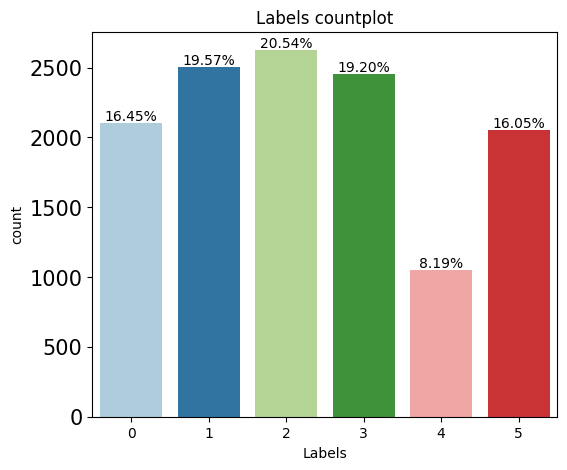

In [ ]:
labeled_barplot(data=data, feature='Labels', perc=True)

- The dataset is relatively balanced except for the "Not-Known" (4) class.

# NLP Text Preprocessing

## Display wordcloud for toxic and non-toxic comments

In [ ]:
def WordCloudGen(data, label):
    """
    this function generates a word cloud based on the specified comment class
    data: dataframe
    label: category  {'half-true': 2, 'false': 1, 'mostly-true': 3, 'true': 5, 'barely-true': 0, 'not-known': 4}
    """
    # step 1: filter the dataset based on the label
    df = data[data['Labels'] == label] #this will return a subset of the data with specified label

    # step 2: join the words in the text
    combined_text = " ".join(df['Text'])

    # step 3: intialize the wordcloud
    wcloud = WordCloud(stopwords=STOPWORDS, random_state=14, width=3000, height=2500,).generate(combined_text)

    # set the figure
    plt.figure(1, figsize=(12,12))

    # display the wordcloud image
    plt.imshow(wcloud, interpolation='bilinear')

    # off the axis
    plt.axis('off')

    # show the plot
    plt.show()

## Display wordcloud of true text

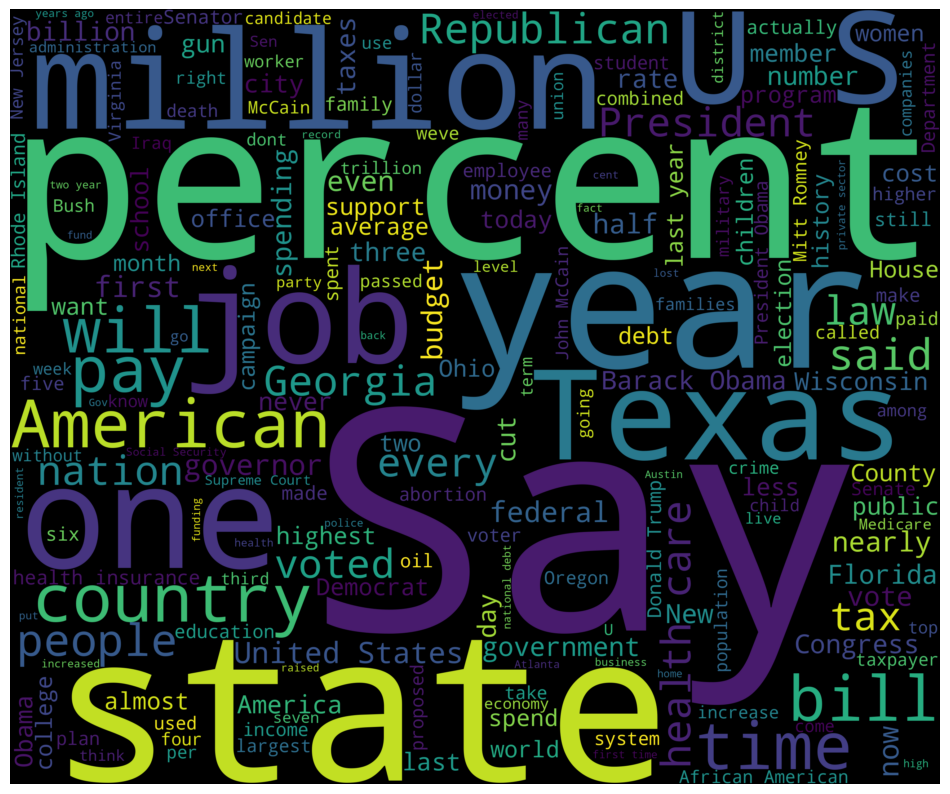

In [ ]:
# displaying the word cloud for the true text
WordCloudGen(data, 5)

- It seems the true new is about US president and election-related contents.

## Display wordcloud of false text

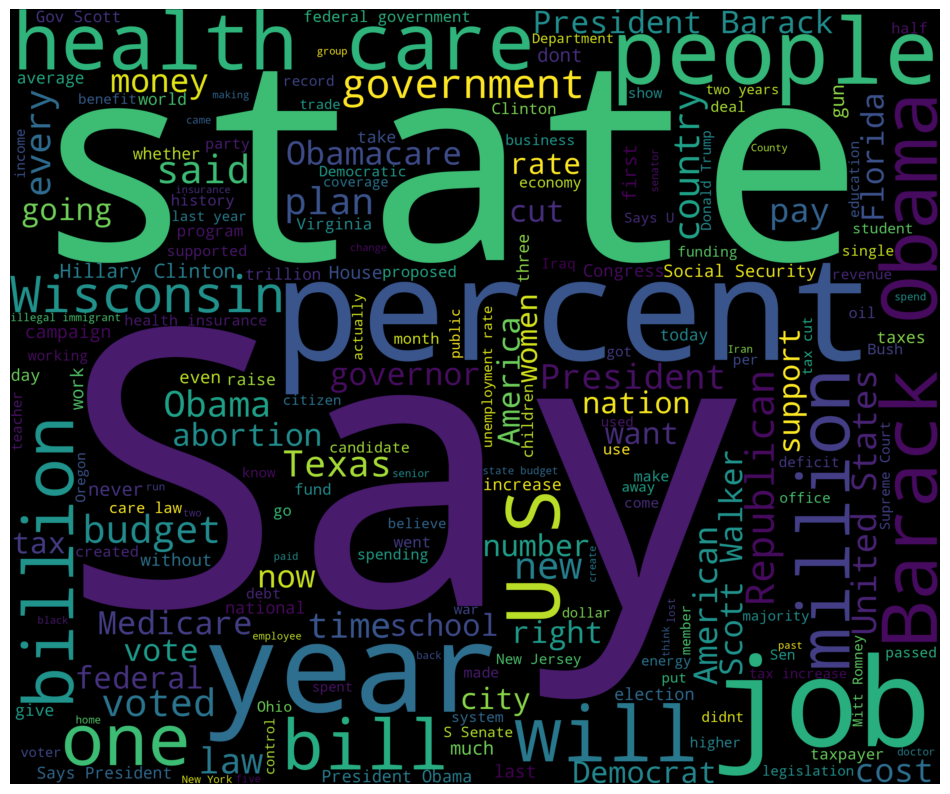

In [ ]:
WordCloudGen(data, 1)

- Both the `true` and `false` contents appear similar. We would need an advanced model to be able to distinguish between the two classes.

## Removing Contractions (converting words like "It's" to "It is")

In [ ]:
def contraction_fixer(text):
    """
    This function fixes the contractions found in the sentence and returns text with no contractions.
    Text: string of words
    """
    clean_text = contractions.fix(text)
    return clean_text

In [ ]:
data['Text'] = data['Text'].apply(contraction_fixer)

## Remove unwanted characters such as: digits and punctuation marks & special charcaters

In [ ]:
def text_cleaner(text):
    """
    This function removes unwanted characters such as: digits and punctuation marks, extra
    whitespaces & special charcaters found in the text.
    it will return only uppercase and lowecased alphabets.
    text: string of words
    """
    cleaned_text = re.sub(pattern = "[^a-zA-Z]", repl=" ", string=text)
    cleaned_text = re.sub(pattern = "\s+", repl=" ", string=cleaned_text)
    return cleaned_text

In [ ]:
data["Text"] = data["Text"].apply(lambda row: text_cleaner(row))


In [ ]:
data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports third trimester abortions on demand,abortion
1,2,When did the decline of coal start It started when natural gas took off that started to begin in President George W Bushs administration,"energy,history,job-accomplishments"
2,3,Hillary Clinton agrees with John McCain by voting to give George Bush the benefit of the doubt on Iran,foreign-policy
3,1,Health care reform legislation is likely to mandate free sex change surgeries,health-care
4,2,The economic turnaround started at the end of my term,"economy,jobs"


## Lowercase the text

In [ ]:
def lowercase(text):
    """
    returns a lowercased string of text.
    text: string of words
    """
    # step1: lowercase each word in the list of tokens
    lowercased_tokens = [word.lower() for word in text.split()]
    # step 2: join the words together
    lowercased_text = " ".join(lowercased_tokens)
    # step 3: return text
    return lowercased_text

In [ ]:
data["Text"] = data.apply(lambda x: lowercase(x['Text']), axis=1)

## Remove Stopwords

In [ ]:
# step1: import corpus
from nltk.corpus import stopwords

# step2: initialize stopwords found in the english languague so far
stop_words = stopwords.words('english')

# step3: define a function to remove stopwords found in the text
def stopword_remover(text):
    """
    the function removes stopwords found in the text and returns the remaining word
    text: string of words
    """
    # remove the word if the word is a stopword
    cleaned_tokens = [word for word in text.split() if word not in stop_words]


    #join the remiaining words back together
    cleaned_text = " ".join(cleaned_tokens)

    # return the cleaned text
    return cleaned_text

#step4: apply the function to the commemt text
data["Text"] = data.apply(lambda x: stopword_remover(x['Text']), axis=1)


## Apply Lemmatization: return the root word for a particular word. (example: returns 'dog' for 'dogs')

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# step1: import wordnetlemmatizer
from nltk.stem import WordNetLemmatizer

# step2: initialize the wn
wn = WordNetLemmatizer()

# step3: define a function to apply lemmatization to words found in the text
def lemmatizer(text):
    """
    the function lemmatize the words in the comment
    text: string of words
    """
    # lemmatize each word
    lemmatized_tokens = [wn.lemmatize(word) for word in text.split()]

    # join the remiaining words back together
    lemmatized_text = " ".join(lemmatized_tokens)

    # return the lemmatized text
    return lemmatized_text

#step4: apply the function to the commemt text
data["Text"] = data.apply(lambda x: lemmatizer(x['Text']), axis=1)

## remove punctuations

In [ ]:
def remove_punctuation(text):
    cleaned_tokens = [word for word in text.split() if word not in string.punctuation]

    # join the remiaining words back together
    cleaned_text = " ".join(cleaned_tokens)

    return cleaned_text

In [ ]:
data["Text"] = data.apply(lambda x: remove_punctuation(x['Text']), axis=1)

In [ ]:
data.head()

,Labels,Text,Text_Tag
0,1,say annies list political group support third trimester abortion demand,abortion
1,2,decline coal start started natural gas took started begin president george w bush administration,"energy,history,job-accomplishments"
2,3,hillary clinton agrees john mccain voting give george bush benefit doubt iran,foreign-policy
3,1,health care reform legislation likely mandate free sex change surgery,health-care
4,2,economic turnaround started end term,"economy,jobs"


## save the cleaned data

In [ ]:
data.to_csv('/content/MyDrive/MyDrive/Files/Projects/Aileadtech_Projects/Masters_Projects/Titi/Dataset/cleaned_news.csv', index=False)

In [ ]:
data.isnull().sum()

Labels      0
Text        0
Text_Tag    2
dtype: int64

## Model Development and Evaluation using Pycaret

In [ ]:
from pycaret.classification import (setup, compare_models, create_model, evaluate_model, finalize_model, tune_model)

## Load the cleaned data

In [ ]:
path = '/content/MyDrive/MyDrive/fake_news_project/cleaned_news.csv'
df = data_reader(path)

df.head()

,Labels,Text,Text_Tag
0,1,say annies list political group support third trimester abortion demand,abortion
1,2,decline coal start started natural gas took started begin president george w bush administration,"energy,history,job-accomplishments"
2,3,hillary clinton agrees john mccain voting give george bush benefit doubt iran,foreign-policy
3,1,health care reform legislation likely mandate free sex change surgery,health-care
4,2,economic turnaround started end term,"economy,jobs"


In [ ]:
df.shape

(12791, 3)

In [ ]:
#drop the Text_tag column
df = df.drop(['Text_Tag'], axis=1)
df

,Labels,Text
0,1,say annies list political group support third trimester abortion demand
1,2,decline coal start started natural gas took started begin president george w bush administration
2,3,hillary clinton agrees john mccain voting give george bush benefit doubt iran
3,1,health care reform legislation likely mandate free sex change surgery
4,2,economic turnaround started end term
...,...,...
12773,2,first time decade import accounted le half oil consumed
12774,3,say donald trump bankrupted company twice four time
12775,5,john mccain george bush absolutely plan universal health care
12776,1,new poll show percent support president plan reform health care mean letting choose keeping private insurance public health insurance plan


## obtain the tf_idf features using pycaret setup

In [ ]:
def setting(path, feat_mode='tf-idf'):
  """
  returns an intialized environment for training using pycaret
  path: path to data
  feat_mode: 'tf-idf' or 'bow'. default:'tf-idf'. specifies the type of feature extraction method to use.
  """
  #read the data
  df = data_reader(path)

  #intialize training environment
  setting = setup(data=df, target='Labels', train_size=0.8,text_features=['Text'], text_features_method=feat_mode)

  return setting

In [ ]:
#path = '/content/MyDrive/MyDrive/Files/Projects/Aileadtech_Projects/Masters_Projects/Titi/Dataset/cleaned_news.csv'
setups = setting(path)

,Description,Value
0,Session id,1575
1,Target,Labels
2,Target type,Multiclass
3,Original data shape,"(12778, 3)"
4,Transformed data shape,"(12778, 9973)"
5,Transformed train set shape,"(10222, 9973)"
6,Transformed test set shape,"(2556, 9973)"
7,Text features,1
8,Categorical features,1
9,Rows with missing values,0.0%


In [ ]:
def set_getter(path):
  """
  gets the transformed train and test sets from training pipeline
  path: path to data
  """
  setups = setting(path)

  x_train, x_test, y_train, y_test = setups.X_train_transformed, setups.X_test_transformed, setups.y_train_transformed,  setups.y_test_transformed

  return x_train, x_test, y_train, y_test

In [ ]:
#to obtain the features using the pipeline
#x_train_tf,x_test_tf, y_train_tf, y_test_tf = set_getter(path)

In [ ]:
x_train_tf,x_test_tf, y_train_tf, y_test_tf = setups.X_train_transformed, setups.X_test_transformed, setups.y_train_transformed, setups.y_test_transformed


## Compare Machine Learning Models

In [ ]:
def ml_compare(path, n_select=3):
  """
  compares machine learning model and returns the top performing n_select number of models
  n_select: int, specifies the number of top models. default=3
  """
  #initialize pipeline
  setups = setting(path)
  #compare top models with 2 fold of cv
  top_models = compare_models(n_select=n_select, fold=2)

  return top_models

In [ ]:
top_models = ml_compare(path)
top_models

,Description,Value
0,Session id,3672
1,Target,Labels
2,Target type,Multiclass
3,Original data shape,"(12782, 2)"
4,Transformed data shape,"(12782, 9995)"
5,Transformed train set shape,"(10225, 9995)"
6,Transformed test set shape,"(2557, 9995)"
7,Text features,1
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.2383,0.5688,0.2383,0.2378,0.2280,0.0640,0.0650,49.3450
rf,Random Forest Classifier,0.2358,0.5692,0.2358,0.2437,0.2227,0.0586,0.0598,30.2300
lr,Logistic Regression,0.2338,0.5697,0.2338,0.2500,0.2246,0.0563,0.0569,30.2150
ridge,Ridge Classifier,0.2301,0.0000,0.2301,0.2314,0.2277,0.0576,0.0578,13.2800
svm,SVM - Linear Kernel,0.2253,0.0000,0.2253,0.2263,0.2240,0.0577,0.0579,16.6550
xgboost,Extreme Gradient Boosting,0.2205,0.5518,0.2205,0.2167,0.2150,0.0444,0.0446,89.2200
lightgbm,Light Gradient Boosting Machine,0.2198,0.5576,0.2198,0.2170,0.2170,0.0468,0.0469,42.1500
knn,K Neighbors Classifier,0.2149,0.5381,0.2149,0.2164,0.2103,0.0394,0.0398,34.5600
gbc,Gradient Boosting Classifier,0.2117,0.5359,0.2117,0.2098,0.1950,0.0272,0.0286,319.2500
ada,Ada Boost Classifier,0.2071,0.5271,0.2071,0.2197,0.1517,0.0220,0.0284,28.3400


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=3672, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=3672, verbose=0, warm_start=False),
 Lo

- the top 3 models based on the displayed metrics namely: Accuracy, AUC, Recall, Precicion, F1 were Random Forest class., Logistic Regression, ExtraTreeClassifier.

- RandomForest Classifier had an Accuracy of 0.236 which means that 23.6% of the total predictions made was correct.
- the logistics and extraa tree classifier had accuracy scores of 0.2338 and 0.2383 respectively.

#### Using pycaret, the best model obtained so far was the ExtraTrees Classifier.

## Tune the Top model

In [ ]:
def model_tuner(path):
  """
  tunes the top model and returns the better model if higher metric scores are obtained, else original model is returned
  path: specified directory path
  """
  top_models = ml_compare(path)

  #tune the model
  tuned_model = tune_model(top_models[0], search_algorithm='random')

  return tuned_model

In [ ]:
#tuned_model = model_tuner(path)

In [ ]:
tuned_model = tune_model(top_models[0], search_algorithm='random', fold=2)
tuned_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.2198,0.5622,0.2198,0.2288,0.2182,0.0637,0.0643
1,0.2126,0.5648,0.2126,0.2235,0.2081,0.0611,0.0623
Mean,0.2162,0.5635,0.2162,0.2261,0.2132,0.0624,0.0633
Std,0.0036,0.0013,0.0036,0.0027,0.0051,0.0013,0.0010


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 10 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=3672, verbose=0, warm_start=False)

- the tuned RandomForest Classifier model did not perform so much better than its original model. Hence, we will proceed to implement Recurrent Neural Networks.

## Obtain the TF-IDF features manually
- the Transformed data shape	of the data when pycaret was used is (12782, 9995). However, this might be the reason for the low performance (High Dimensionality).
- We will proceed by manually obtaining the tf-idf features of specified dimension before using pycaret.

In [ ]:
def tf_vectorizer(path, max_features=300):
  """
  returns tf-idf vectors of the data with specified max_features
  args:
      path: file path to data
      max_features: default=100, specified number of features to consider
  """
  #read the data
  df = data_reader(path)
  #instantiate tfidf vectorizer
  tfv = TfidfVectorizer(max_features=max_features)
  #obtain sparse vectors
  tf_vec = tfv.fit_transform(df['Text']).toarray()
  #convert to a dataframe
  feat = pd.DataFrame(tf_vec)
  #merge with target labels
  data = pd.concat([feat, df.Labels], axis=1)

  return data

In [ ]:
data = tf_vectorizer(path)

In [ ]:
data.shape

(12778, 301)

- data set has 12,791 rows and 301 columns

In [ ]:
#view top 5 rows
data.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Labels
0,0.469153,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.0,0.0,0.405412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


## use pycaret to get an overview of the performances of different Machine Learning models automatically.

In [ ]:
def setting2(path):
  """
  returns an intialized environment for training using pycaret
  path: path to data
  feat_mode: 'tf-idf' or 'bow'. default:'tf-idf'. specifies the type of feature extraction method to use.
  """
  #read the data
  data = tf_vectorizer(path)

  #intialize training environment
  setting = setup(data=data, target='Labels', train_size=0.8)

  return setting

In [ ]:
def ml_compare2(path, n_select=3):
  """
  compares machine learning model and returns the top performing n_select number of models
  n_select: int, specifies the number of top models. default=3
  """
  #initialize pipeline
  setups = setting2(path)
  #compare top models with 2 fold of cv
  top_models = compare_models(n_select=n_select, fold=2)

  return top_models

In [ ]:
top_models = ml_compare2(path)


,Description,Value
0,Session id,8736
1,Target,Labels
2,Target type,Multiclass
3,Original data shape,"(12778, 301)"
4,Transformed data shape,"(12778, 301)"
5,Transformed train set shape,"(10222, 301)"
6,Transformed test set shape,"(2556, 301)"
7,Numeric features,300
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.2407,0.5681,0.2407,0.2386,0.2347,0.0682,0.0686,3.1500
lr,Logistic Regression,0.2344,0.5684,0.2344,0.2346,0.2273,0.0593,0.0598,3.4150
et,Extra Trees Classifier,0.2342,0.5639,0.2342,0.2327,0.2300,0.0617,0.0620,2.7650
ridge,Ridge Classifier,0.2333,0.0000,0.2333,0.2328,0.2269,0.0586,0.0590,0.2350
xgboost,Extreme Gradient Boosting,0.2302,0.5551,0.2302,0.2264,0.2241,0.0562,0.0566,6.9350
lightgbm,Light Gradient Boosting Machine,0.2295,0.5620,0.2295,0.2263,0.2265,0.0585,0.0587,15.0750
lda,Linear Discriminant Analysis,0.2280,0.5638,0.2280,0.2261,0.2264,0.0592,0.0593,0.7700
gbc,Gradient Boosting Classifier,0.2254,0.5551,0.2254,0.2199,0.2119,0.0457,0.0467,16.0550
ada,Ada Boost Classifier,0.2208,0.5469,0.2208,0.2298,0.1833,0.0365,0.0417,0.7150
qda,Quadratic Discriminant Analysis,0.2111,0.5327,0.2111,0.2014,0.1962,0.0374,0.0388,0.5450


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

- the performances of the models were still low despite reduction in the feature size.

## We will experiment further by obtaining Skip-Gram word embeddings and use this feature and original target on the Pycaret module.
- Here, we will experiment with a sample pre-trained word embeddings such as the `Word2Vec`

In [ ]:
df.head()

,Labels,Text,Text_Tag
0,1,say annies list political group support third trimester abortion demand,abortion
1,2,decline coal start started natural gas took started begin president george w bush administration,"energy,history,job-accomplishments"
2,3,hillary clinton agrees john mccain voting give george bush benefit doubt iran,foreign-policy
3,1,health care reform legislation likely mandate free sex change surgery,health-care
4,2,economic turnaround started end term,"economy,jobs"


In [ ]:
#import relevant packages
from gensim.models import Word2Vec

#append all comments in a list
parent_list = []

#for each row of Text column
for comments in df['Text']:
  #split each string into a list of strings
   tokens = comments.split()
  #append the list into the parent list
   parent_list.append(tokens)

#define the word2vec (skipgram) model of 100-Dimension with words with minimum count > 5
wv_model = Word2Vec(sentences=parent_list, min_count=5, sg=1)

In [ ]:
#save the word2vec model
#wv_model.save("/content/MyDrive/MyDrive/fake_news_project/models/wv_model.model")

In [ ]:
def word_embeddings_getter(model, token_list):
    """
    this function returns an array of word-embedding vectors for each token found in the list of tokens
    model: model
    token_list: each itirative sentence in a list

    """
    embeddings = []
    vocab = set(model.wv.key_to_index) #get vocabulary

    for token in token_list: #for each  word in token_list
        if token in vocab: #if the token (word) is found in the vocab
            embeddings.append(model.wv.get_vector(token))#append the word embeddings to the list

    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return(np.mean(embeddings, axis=0)) #return the mean of word embeddings for each word

def avg_word_emb(model, sentence):
    """
    this function applies the get_word_embeddings on each sentence
    model: model
    sentence: list containing a list of tokens
    """

    for token_list in sentence:

        word_embedding = [word_embeddings_getter(model, token_list) for token_list in sentence]
        #this will put every averaged word embedding for each sentence in a list hence we are able to retain the
        #shape of the array

        return np.array(word_embedding)

In [ ]:
#step4: get the word embeddings
sg_feat = avg_word_emb(model=wv_model, sentence=parent_list)
target = df.Labels


In [ ]:
data = pd.concat([pd.DataFrame(sg_feat), target], axis=1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Labels
0,-0.104167,0.067904,0.057485,-0.005962,0.029632,-0.305748,0.152510,0.304766,-0.063730,-0.103584,...,0.089730,0.062990,0.114374,0.267165,0.126079,0.116622,-0.150301,0.076286,-0.026200,1
1,-0.069469,0.083877,0.078379,-0.019772,0.118506,-0.169678,0.169309,0.304333,-0.250037,-0.090922,...,0.063836,-0.149833,0.030235,0.185526,0.215714,0.243675,-0.272780,-0.009961,-0.049753,2
2,-0.292334,0.166128,0.051395,-0.207337,0.046143,-0.222216,0.159784,0.322730,-0.172521,-0.114892,...,0.074093,-0.134695,0.086425,0.349369,0.319068,0.051408,-0.263953,-0.066477,-0.093285,3
3,-0.200115,-0.047983,0.115769,0.023650,-0.018315,-0.374467,0.217606,0.431509,-0.119321,-0.190386,...,0.107335,0.173961,0.182645,0.423209,0.104686,0.077323,-0.010116,0.178688,0.044778,1
4,0.058449,0.026057,-0.023337,-0.039160,0.098214,-0.290605,0.207505,0.298691,-0.196762,-0.126121,...,0.062911,-0.150508,0.029257,0.171528,0.131103,0.261964,-0.121848,0.069529,0.006492,2


In [ ]:
s2 = setup(data=data, train_size=0.8, target='Labels')
s2

,Description,Value
0,Session id,2310
1,Target,Labels
2,Target type,Multiclass
3,Original data shape,"(12782, 101)"
4,Transformed data shape,"(12782, 101)"
5,Transformed train set shape,"(10225, 101)"
6,Transformed test set shape,"(2557, 101)"
7,Numeric features,100
8,Preprocess,True
9,Imputation type,simple


In [ ]:
top_models = compare_models(n_select=3)
top_models

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:58:18
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.2395,0.0000,0.2395,0.2553,0.2117,0.0583,0.0609,0.0730
lr,Logistic Regression,0.2358,0.5777,0.2358,0.2410,0.2068,0.0534,0.0558,2.4250
rf,Random Forest Classifier,0.2338,0.5687,0.2338,0.2340,0.2249,0.0576,0.0581,12.3770
lda,Linear Discriminant Analysis,0.2334,0.5752,0.2334,0.2310,0.2247,0.0583,0.0590,0.2820
gbc,Gradient Boosting Classifier,0.2333,0.5754,0.2333,0.2296,0.2216,0.0556,0.0565,204.4900
et,Extra Trees Classifier,0.2324,0.5679,0.2324,0.2333,0.2240,0.0560,0.0566,3.8920
xgboost,Extreme Gradient Boosting,0.2277,0.5613,0.2277,0.2243,0.2214,0.0522,0.0525,22.3390
ada,Ada Boost Classifier,0.2259,0.5570,0.2259,0.2193,0.2099,0.0489,0.0501,6.8490
qda,Quadratic Discriminant Analysis,0.2155,0.5576,0.2155,0.2242,0.2122,0.0606,0.0615,0.1590
knn,K Neighbors Classifier,0.2145,0.5353,0.2145,0.2158,0.2105,0.0406,0.0410,0.2960


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.2395,0.0000,0.2395,0.2553,0.2117,0.0583,0.0609,0.0730
lr,Logistic Regression,0.2358,0.5777,0.2358,0.2410,0.2068,0.0534,0.0558,2.4250
rf,Random Forest Classifier,0.2338,0.5687,0.2338,0.2340,0.2249,0.0576,0.0581,12.3770
lda,Linear Discriminant Analysis,0.2334,0.5752,0.2334,0.2310,0.2247,0.0583,0.0590,0.2820
gbc,Gradient Boosting Classifier,0.2333,0.5754,0.2333,0.2296,0.2216,0.0556,0.0565,204.4900
et,Extra Trees Classifier,0.2324,0.5679,0.2324,0.2333,0.2240,0.0560,0.0566,3.8920
lightgbm,Light Gradient Boosting Machine,0.2283,0.5675,0.2283,0.2282,0.2229,0.0528,0.0532,30.8300
xgboost,Extreme Gradient Boosting,0.2277,0.5613,0.2277,0.2243,0.2214,0.0522,0.0525,22.3390
ada,Ada Boost Classifier,0.2259,0.5570,0.2259,0.2193,0.2099,0.0489,0.0501,6.8490
qda,Quadratic Discriminant Analysis,0.2155,0.5576,0.2155,0.2242,0.2122,0.0606,0.0615,0.1590


[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                 max_iter=None, positive=False, random_state=2310, solver='auto',
                 tol=0.0001),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=2310, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=2310, 

# Recurrent Neural Networks.
## SimpleRNN

## Tokenize the texts


In [ ]:
df.head()

,Labels,Text,Text_Tag
0,1,say annies list political group support third ...,abortion
1,2,decline coal start started natural gas took st...,"energy,history,job-accomplishments"
2,3,hillary clinton agrees john mccain voting give...,foreign-policy
3,1,health care reform legislation likely mandate ...,health-care
4,2,economic turnaround started end term,"economy,jobs"


In [ ]:
def vectorizer(path, num_words=1000):
  """
  this fn tokenizes the texts into a sequence of integers.
  path: file location in dir
  num_words: (default=1000) max number of unique words in the corpus to keep
  """
  #read data from storage
  df = data_reader(path)

  #instantiate the tokenizer
  tk = Tokenizer(num_words=num_words)

  #fit instance to text
  tk.fit_on_texts(df['Text'].values)

  #convert text to sequence of integers
  X = tk.texts_to_sequences(df['Text'].values)

  return X

In [ ]:
feature = vectorizer(path)
#feature


## pad the sequence
- to reduce the problem of sparisity, instead of using maximum length of comment as the max length, i will obtain the descriptive stats of the length of all the text as this will help me know the best padding length to use.

In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
length = []
#for each row in the data
for i in range(len(df['Text'].values)):
  #append the length of each word to the list
  length.append(len(df['Text'][i].split()))

#convert the list to a series
length_series = pd.Series(length)
#give a descriptive stats of it
print(length_series.describe())

count    12782.000000
mean        10.539587
std          6.406963
min          1.000000
25%          7.000000
50%         10.000000
75%         13.000000
max        333.000000
dtype: float64


- the result indicates that 75% of the comments are not longer than 13 word in length.
- the max. length of the comments however is 333.
- the minimum text is just a word long.


#### We will set the maxlen of the padding operation to 50.

In [ ]:
def padder(path, time_steps=50):
  """
  pads the sequence to a unifrom length and split into train and test sets.
  path: specified directory
  time_steps: (default=50) specified length of each token sequence for truncation/padding operation
  """
  #get the tokenized text
  feature = vectorizer(path)

  #pad the sequence
  feature = pad_sequences(feature, maxlen=time_steps)

  #specify taregt
  target = df.Labels

  #split feature and target to train and test sets
  x_train, x_test, y_train, y_test = train_test_split(feature, target, random_state=0,stratify=target,
                                                   test_size=0.2)

  return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = padder(path)

print(f'{x_train.shape}\n {y_train.shape}')

(10225, 50)
 (10225,)


## Encode Target

In [ ]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

## define the metrics

In [ ]:
import tensorflow as tf
#define metrics
indices = [

       tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
       tf.keras.metrics.Precision(name='precision'),
       tf.keras.metrics.Recall(name='recall'),
       tf.keras.metrics.AUC(name='auc')
]

## define callbacks

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=5)

#define modelcheckpoint to save best model

#path to project directory specially for models
temporal_path = '/content/MyDrive/MyDrive/fake_news_project/models'

rnn_mc = ModelCheckpoint(filepath = temporal_path, save_best_only=True, monitor='val_accuracy', mode='max')


## clear backend

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

##  build the model

In [ ]:
def RNN_model(embedding_dims=100, hidden_dims=32):
    model = Sequential()

    #obtain dense vectors of 100D
    model.add(Embedding(1000, output_dim=embedding_dims,input_length=x_train.shape[1]))
    #apply dropout
    model.add(SpatialDropout1D(0.2))
    #add a vanilla rnn for recurrent operation
    model.add(SimpleRNN(units=hidden_dims))
    #add a dense layer for further representation
    model.add(Dense(units=16, activation='relu'))
    #add a dense layer for classification
    model.add(Dense(y_train.nunique(), activation ='softmax'))

    #compile the network
    model.compile(optimizer='adam', metrics=indices, loss='categorical_crossentropy')

    return model

In [ ]:
rnn_1 = RNN_model()

rnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           100000    
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 104886 (409.71 KB)
Trainable params: 104886 (409.71 KB)
Non-trainable params: 0 (0.00 Byte)
________________

## train and evaluate the model

In [ ]:
#train the network
history = rnn_1.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=30, callbacks=[es, rnn_mc])

Epoch 1/30
128/128 [==============================] - 36s 272ms/step - loss: 1.7631 - accuracy: 0.2095 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5741 - val_loss: 1.7652 - val_accuracy: 0.2112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5713
Epoch 2/30
128/128 [==============================] - 5s 37ms/step - loss: 1.6899 - accuracy: 0.2823 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6570 - val_loss: 1.7665 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5810
Epoch 3/30
128/128 [==============================] - 3s 23ms/step - loss: 1.5595 - accuracy: 0.3795 - precision: 0.6412 - recall: 0.0103 - auc: 0.7357 - val_loss: 1.8276 - val_accuracy: 0.2196 - val_precision: 0.2143 - val_recall: 0.0059 - val_auc: 0.5803
Epoch 4/30
128/128 [==============================] - 4s 30ms/step - loss: 1.3985 - accuracy: 0.4559 - precision: 0.6843 - recall: 0.1153 - auc: 0.7995 - val_loss: 1.9283 - val_accuracy: 0.2122 -

### Visualize the RNN Model Performance

In [ ]:
def view_perf(history):
  """
  plots the accuracy, val_accuracy and recall_score against epochs
  """
  #define accuracy
  acc = history.history['accuracy']

  #define validation_accuracy
  val_acc = history.history['val_accuracy']

  #specify epochs
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (5,5)) #set figure size
  plt.plot(epochs, acc, label="Train Accuracy") #plot accuracy against epochs
  plt.plot(epochs, val_acc, label="validation Accuracy") #plot val_acc against epcohs
  plt.xlabel("Epochs")
  plt.ylabel("Categorical Accuracy Score")

  plt.legend(loc='best') #display the legends at the best location in the chart

  plt.show()#show the plot

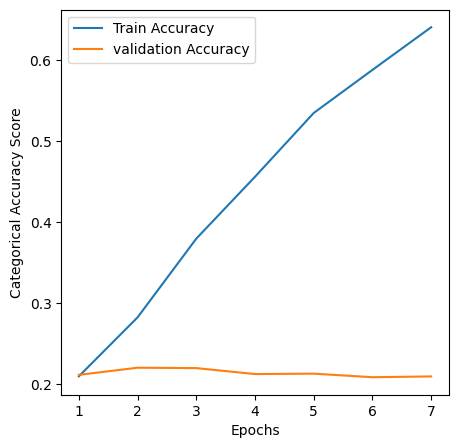

In [ ]:
view_perf(history)

- this chart indicates a strong level of overfiting accross all epochs as validation accuracy was very much lower than train accuracy.

In [ ]:
#evaluate performance on test set
rnn_1.evaluate(x_test, y_test_c)

80/80 [==============================] - 0s 6ms/step - loss: 2.4430 - accuracy: 0.2108 - precision: 0.2249 - recall: 0.1181 - auc: 0.5611


[2.443013906478882,
 0.2107938975095749,
 0.22486969828605652,
 0.1181071549654007,
 0.5610514879226685]

- A similar low performance was observed on the test set. This confirms that the model is not generalizing well.

## Balancing the Dataset by using class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute class weight for each subcategory of the target
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = dict(enumerate(class_weight))
class_weight_dic


{0: 1.0131787554498612,
 1: 0.8516575045810428,
 2: 0.8115079365079365,
 3: 0.8681439972830701,
 4: 2.0336117740652346,
 5: 1.0384927889498274}

## Build an RNN network that takes cognizance of the weight of each classes.
- the reason behind this approach is to train the model to have a balanced view of each subcategory as this might reduce the level of overfiting.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

##  build the model

In [ ]:
rnn_2 = RNN_model()

rnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           100000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 104886 (409.71 KB)
Trainable params: 104886 (409.71 KB)
Non-trainable params: 0 (0.00 Byte)
______________

## train and evaluate the model

In [ ]:
history = rnn_2.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=30, callbacks=[es, rnn_mc], class_weight=class_weight_dic)

Epoch 1/30
128/128 [==============================] - 6s 35ms/step - loss: 1.7890 - accuracy: 0.1730 - precision: 0.2249 - recall: 0.0281 - auc: 0.5187 - val_loss: 1.7913 - val_accuracy: 0.1648 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5190
Epoch 2/30
128/128 [==============================] - 4s 28ms/step - loss: 1.7028 - accuracy: 0.2714 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6445 - val_loss: 1.7785 - val_accuracy: 0.2015 - val_precision: 1.0000 - val_recall: 4.8900e-04 - val_auc: 0.5655
Epoch 3/30
128/128 [==============================] - 3s 22ms/step - loss: 1.5363 - accuracy: 0.3627 - precision: 0.6027 - recall: 0.0215 - auc: 0.7270 - val_loss: 1.8416 - val_accuracy: 0.2024 - val_precision: 0.1782 - val_recall: 0.0088 - val_auc: 0.5647
Epoch 4/30
128/128 [==============================] - 3s 23ms/step - loss: 1.3424 - accuracy: 0.4449 - precision: 0.6857 - recall: 0.0984 - auc: 0.7944 - val_loss: 1.9384 - val_accuracy: 0.2068 - val_precision

### Visualize the RNN Model Performance

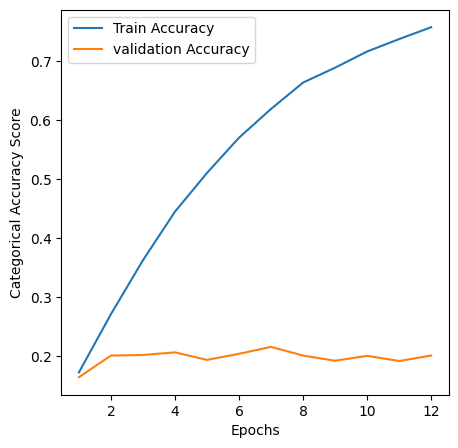

In [ ]:
view_perf(history)

- similarly, this chart indicates a strong level of overfiting accross all epochs.

In [ ]:
#evaluate performance on test set
rnn_1.evaluate(x_test, y_test_c)

80/80 [==============================] - 1s 5ms/step - loss: 2.4430 - accuracy: 0.2108 - precision: 0.2249 - recall: 0.1181 - auc: 0.5611


[2.443013906478882,
 0.2107938975095749,
 0.22486969828605652,
 0.1181071549654007,
 0.5610514879226685]

- A similar low performance was observed on the test set. This confirms that the model is not generalizing well.

## Exploring Long Short Term Memory (LSTM) Network.
- LSTM uses the principle of 'Gating Mechanism' to understand and retain the long range dependencies in sequential data.
- It is able to prevent varnishing and exploding gradient problems that may reduce overfiting.
- However to also reduce overfiting, we will reduce the output_dimension of the embediing layer to 30.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def lstm(embedding_dims=30, hidden_dims=32):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings  30
  hidden_dims: number of neurons
  """
  #define structure to be a linear stack of layers
  model = Sequential()

  #add an ebedding layer to obtain dense representation of text sequence
  model.add(Embedding(1000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  #add an LSTM layer
  model.add(LSTM(units=hidden_dims))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))

  #add a dense
  model.add(Dense(y_train.nunique(), activation ='softmax'))

  model.compile(optimizer='adam', metrics=indices, loss='categorical_crossentropy')

  return model

In [ ]:
# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

# #define modelcheckpoint to save best model
path = '/content/MyDrive/MyDrive/fake_news_project/models'
lstm_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
lstm_1 = lstm()

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            30000     
                                                                 
 lstm (LSTM)                 (None, 32)                8064      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 38694 (151.15 KB)
Trainable params: 38694 (151.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#train the network
lstm_history = lstm_1.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, lstm_mc])

Epoch 1/15
128/128 [==============================] - 8s 46ms/step - loss: 1.7606 - accuracy: 0.2153 - precision: 0.2759 - recall: 0.0016 - auc: 0.5787 - val_loss: 1.7628 - val_accuracy: 0.2073 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5803
Epoch 2/15
128/128 [==============================] - 5s 41ms/step - loss: 1.7331 - accuracy: 0.2375 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6054 - val_loss: 1.7400 - val_accuracy: 0.2220 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6014
Epoch 3/15
128/128 [==============================] - 5s 43ms/step - loss: 1.6838 - accuracy: 0.2663 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6520 - val_loss: 1.7226 - val_accuracy: 0.2499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6266
Epoch 4/15
128/128 [==============================] - 5s 36ms/step - loss: 1.6256 - accuracy: 0.3132 - precision: 0.3333 - recall: 1.2225e-04 - auc: 0.6893 - val_loss: 1.7558 - val_accuracy

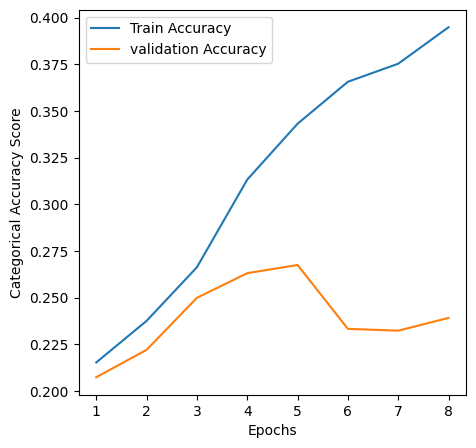

In [ ]:
view_perf(lstm_history)

- So far, the highest validation Categorical accuracy of approxiamtely 0.27 was obtained using the LSTM network.

- However, the model is still overfitting.

- The next approach will be to use L1 regularization on the recurrent_regularizer of the the LSTM layer. This may help reduce the level of overfiting observed.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def lstm2(embedding_dims=30, hidden_dims=32):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings default 100
  hidden_dims: number of neurons
  """
  model = Sequential()

  model.add(Embedding(1000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  model.add(LSTM(units=hidden_dims,recurrent_regularizer=keras.regularizers.l1(0.3)))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))

  model.add(Dense(y_train.nunique(), activation ='softmax'))

  model.compile(optimizer='adam', metrics=indices, loss='categorical_crossentropy')

  return model

In [ ]:
# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

#define modelcheckpoint to save best model
path = '/content/MyDrive/MyDrive/fake_news_project/models/lstm2'

#create directory for saving model
#import os
#os.mkdir(path)

lstm2_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
lstm_2 = lstm2()

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            30000     
                                                                 
 lstm (LSTM)                 (None, 32)                8064      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 38694 (151.15 KB)
Trainable params: 38694 (151.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm2_history = lstm_2.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, lstm2_mc])

Epoch 1/15
128/128 [==============================] - 7s 45ms/step - loss: 38.0636 - accuracy: 0.2067 - precision: 0.2984 - recall: 0.0036 - auc: 0.5779 - val_loss: 9.3011 - val_accuracy: 0.2230 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5908
Epoch 2/15
128/128 [==============================] - 5s 37ms/step - loss: 3.8670 - accuracy: 0.2462 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6238 - val_loss: 1.9701 - val_accuracy: 0.2577 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6139
Epoch 3/15
128/128 [==============================] - 2s 17ms/step - loss: 1.8341 - accuracy: 0.2696 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6585 - val_loss: 1.8758 - val_accuracy: 0.2489 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6198
Epoch 4/15
128/128 [==============================] - 2s 19ms/step - loss: 1.7810 - accuracy: 0.3051 - precision: 0.3333 - recall: 1.2225e-04 - auc: 0.6848 - val_loss: 1.8872 - val_accurac

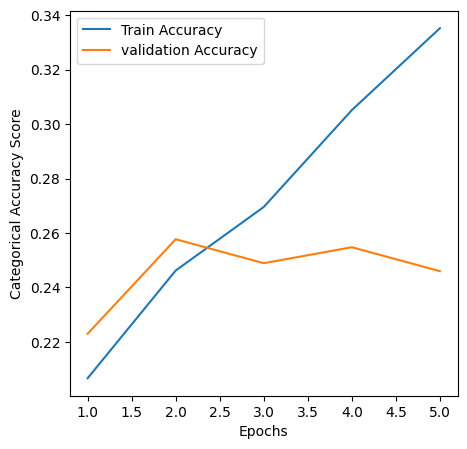

In [ ]:
view_perf(lstm2_history)

- the low performance and overfiting observed still persists.

## Exploring Gated Recurrent Network
- The idea behind using GRU is that it is similar to LSTM as they are both able to handle long range inter dependencies. However, the LSTM network architecture is more complex than the GRU because unlike the lSTm that has 3 gates, the GRU has 2 gates namely: the reset gate and the update gate.
- The reset gate decides what information to forget from the previous state, and the update gate determines how much of the new information is incorporated into the current state.
- this simpler nature might help in reducing the overfiting observed thus far.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def gru_n(embedding_dims=30, hidden_dims=32):
  """
  returns a compiled GRU architecture
  embedding_dims : the desired shape of embeddings default 100
  hidden_dims: number of neurons
  """
  model = Sequential()

  model.add(Embedding(1000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  model.add(GRU(units=hidden_dims, kernel_regularizer=keras.regularizers.l1(0.1), recurrent_regularizer=keras.regularizers.l1(0.1)))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))

  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='categorical_crossentropy')

  return model

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

# define modelcheckpoint to save best model
path = '/content/MyDrive/MyDrive/fake_news_project/models/gru'
#os.mkdir(path)

gru_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
gru = gru_n()

gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 30)            30000     
                                                                 
 gru (GRU)                   (None, 32)                6144      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 36774 (143.65 KB)
Trainable params: 36774 (143.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_gru = gru.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, gru_mc])

Epoch 1/15
128/128 [==============================] - 7s 39ms/step - loss: 30.0772 - accuracy: 0.2137 - precision: 0.1973 - recall: 0.4310 - auc: 0.5506 - val_loss: 10.4657 - val_accuracy: 0.1980 - val_precision: 0.1874 - val_recall: 0.7496 - val_auc: 0.5715
Epoch 2/15
128/128 [==============================] - 2s 18ms/step - loss: 4.2558 - accuracy: 0.2072 - precision: 0.1926 - recall: 0.7013 - auc: 0.5760 - val_loss: 1.9945 - val_accuracy: 0.1980 - val_precision: 0.1967 - val_recall: 0.5902 - val_auc: 0.5680
Epoch 3/15
128/128 [==============================] - 3s 20ms/step - loss: 1.8717 - accuracy: 0.2033 - precision: 0.1959 - recall: 0.6138 - auc: 0.5734 - val_loss: 1.8384 - val_accuracy: 0.1980 - val_precision: 0.1967 - val_recall: 0.5902 - val_auc: 0.5711
Epoch 4/15
128/128 [==============================] - 3s 22ms/step - loss: 1.8299 - accuracy: 0.2072 - precision: 0.1955 - recall: 0.6203 - auc: 0.5734 - val_loss: 1.8337 - val_accuracy: 0.1980 - val_precision: 0.1967 - val_rec

In [ ]:
history_gru = gru.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es])

Epoch 1/15
128/128 [==============================] - 10s 44ms/step - loss: 1.7661 - accuracy: 0.2050 - precision: 0.1873 - recall: 0.7056 - auc: 0.5609 - val_loss: 1.7617 - val_accuracy: 0.1980 - val_precision: 0.1874 - val_recall: 0.7496 - val_auc: 0.5717
Epoch 2/15
128/128 [==============================] - 5s 39ms/step - loss: 1.7577 - accuracy: 0.2000 - precision: 0.1843 - recall: 0.9015 - auc: 0.5723 - val_loss: 1.7613 - val_accuracy: 0.1980 - val_precision: 0.1827 - val_recall: 0.9134 - val_auc: 0.5709
Epoch 3/15
128/128 [==============================] - 6s 49ms/step - loss: 1.7564 - accuracy: 0.2009 - precision: 0.1839 - recall: 0.9192 - auc: 0.5736 - val_loss: 1.7610 - val_accuracy: 0.1980 - val_precision: 0.1827 - val_recall: 0.9134 - val_auc: 0.5709
Epoch 4/15
128/128 [==============================] - 5s 36ms/step - loss: 1.7569 - accuracy: 0.2071 - precision: 0.1841 - recall: 0.9073 - auc: 0.5748 - val_loss: 1.7610 - val_accuracy: 0.1980 - val_precision: 0.1827 - val_reca

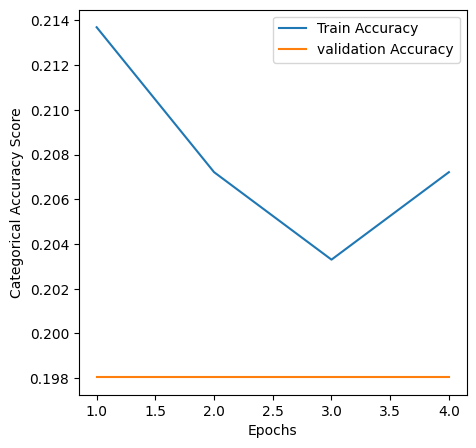

In [ ]:
view_perf(history_gru)

- an average val recall score of 0.85% was obtained, this means that on average  the model was able to classify 85% of the negative comments in the data.
- an average val accuracy of 0.81% indicates that 81% of comments predicted to be toxic were truly toxic.
- Adding a dropout layer did not seem to improve the model.

# Implementing BERT

# Import relevant libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.3 MB/s eta 0:00:00


In [ ]:
import torch #pytorch module
import torch.nn as nn #import neural network
import transformers #import
from transformers import AutoModel, BertForTokenClassification, BertTokenizerFast #for tokenization and model creation
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler #to load the data in batches
from transformers import AdamW #optimizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:
df.head()

,Labels,Text,Text_Tag
0,1,say annies list political group support third trimester abortion demand,abortion
1,2,decline coal start started natural gas took started begin president george w bush administration,"energy,history,job-accomplishments"
2,3,hillary clinton agrees john mccain voting give george bush benefit doubt iran,foreign-policy
3,1,health care reform legislation likely mandate free sex change surgery,health-care
4,2,economic turnaround started end term,"economy,jobs"


In [ ]:
def data_splitter(data, test_size, train_size):
  """
  #splits the data into train, val and test sets
  data: data
  test_size: size of test set
  train_size: size ot train set
  """


  x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['Labels'], train_size=train_size, test_size=test_size, stratify = df['Labels'], random_state=0)

  #categorize the target sets
  # y_train = to_categorical(y_train)
  # y_val= to_categorical(y_val)
  # y_test = to_categorical(y_test)

  return x_train, x_test, y_train, y_test

# Preprocess the data and create DataLoader
def preprocess_data(feature, label, tokenizer):
    """
    returns a tensor dataset of dataset that is pushed to GPu for improved processing.
    feature: features in the data
    label : target
    tokenizer: initalized tokenizer
    """
    inputs = tokenizer(feature.tolist(), padding=True, truncation=True, return_tensors="pt")
    ids = torch.tensor(inputs['input_ids']).to(device)
    mask = torch.tensor(inputs['attention_mask']).to(device)
    labels = torch.tensor(label.tolist()).long().to(device)

    dataset = TensorDataset(ids, mask, labels)
    print(ids.shape)
    print(mask.shape)
    print(labels.shape)

    return dataset



In [ ]:
x_train, x_test, y_train, y_test = data_splitter(df, test_size=0.07, train_size=0.07)

In [ ]:
if torch.cuda.is_available(): #if cuda is available
  device = torch.device("cuda") # use cuda to accelerate computations on GPU.

else: #else use "cpu"
  device = torch.device("cpu")

device

device(type='cuda')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=y_train.nunique())  # 6 for 6 labels
bert.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# get train, validation, and test datasets
train_set = preprocess_data(x_train, y_train, tokenizer)
test_set = preprocess_data(x_test, y_test, tokenizer)

# sample the train dataset randomly
train_sampler = RandomSampler(train_set) #randomly sample the dataset
train_loader = DataLoader(train_set, sampler=train_sampler, batch_size=32) #Combine the tensor dataset and a sampler,

# sample the test dataset randomly
test_sampler = RandomSampler(test_set) #randomly sample the dataset
test_loader = DataLoader(test_set, sampler=test_sampler, batch_size=32) #Combine the tensor dataset and a sampler,

# Set up optimizer
bert_optimizer = torch.optim.AdamW(bert.parameters(), lr=1e-5)



<ipython-input-19-3eb23747fe8a>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ids = torch.tensor(inputs['input_ids']).to(device)
<ipython-input-19-3eb23747fe8a>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(inputs['attention_mask']).to(device)


torch.Size([894, 350])
torch.Size([894, 350])
torch.Size([894])
torch.Size([895, 38])
torch.Size([895, 38])
torch.Size([895])


In [ ]:
# Fine-tune the model
bert.train() #set the model in train mode

target = [] #store target
result = [] #to store output
loss_result = [] # to store loss value
for epoch in range(1):  # You can adjust the number of epochs
    for batch in train_loader:

        bert_optimizer.zero_grad()
        outputs = bert(batch[0], attention_mask=batch[1], labels=batch[2]) #process input data to make prediction

        odds = outputs.logits #get the logit of the output

        # Apply softmax to the logits
        probabilities = F.softmax(odds, dim=-1)

        probabilities = probabilities.detach().cpu().numpy() #model predictions are stored on GPU, so push to CPU

        target.append(batch[2].detach().cpu().numpy()) #save the randomly sampled target as a numpy array

        result.append(probabilities) #append the probabilty to the result

        loss = outputs.loss #compute the loss

        loss_result.append(loss) #append the loss to the loss_result list

        loss.backward() #perform backward propragation
        bert_optimizer.step() #applies an optimization algorithm to update the model's parameters.


In [ ]:
len(result)

28

In [ ]:
len(target)

28

In [ ]:
#store all the result and target in the sublist into a separate list
output_list = []
target_list = []

for sub_list, sub_target in zip(result, target): #for eeach sublist in result and target
  output_list.extend(sub_list) #compile the sublist of the output into a single list
  target_list.extend(sub_target)  #compile the sublist of the target into a single list

print(len(output_list), len(target_list))

894 894


In [ ]:
def printClassificationReport(y_true, preds):
  """
  returns a classification report for the predictions made using the bert model
  y_true : true target labels
  preds: output prediction from the bert model
  """
  y_pred = np.argmax(preds, axis = 1) #return the class of each probability prediction (0 or 1) for each row in the column
  y_true = np.array(y_true) #return an array of the target class

  print(classification_report(y_true, y_pred)) #print classification report

In [ ]:
printClassificationReport(target_list, output_list)

              precision    recall  f1-score   support

           0       0.19      0.31      0.24       147
           1       0.23      0.42      0.29       175
           2       0.18      0.04      0.07       184
           3       0.25      0.30      0.27       172
           4       0.00      0.00      0.00        73
           5       0.19      0.10      0.14       143

    accuracy                           0.22       894
   macro avg       0.17      0.20      0.17       894
weighted avg       0.19      0.22      0.19       894



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- The performance of the BERT model fails to show improved performance in classifying each category especially category 4.
- However, this may be due to the fact that the BERT model was trained with only 7% of the data due to computational constraints.
- The Accuracy score of 0.22 indicates that only 22% of the entire predicition was correct.

## Performance Improvement Strategy (Adding Secondary Data)
- We aim to improve the performance of the model by adding secondary data.
- This will likely reduce the level of overfiting as well.

- Each collections of fake news dataset obtained had been cleaned, augmented, and preprocessed.
- the label in the dataset is described as follows:
  - 1: unreliable (fake news)
  - 0: reliable (true news)

- It is worth noting that the format of the labels in the secondary data does not match that of the original data, hence we will restructure the labels of the original data to be similar to the secondary data.

In [ ]:
def reader(path):
    """
    reads csv from path
    """
    data = pd.read_csv(path)
    return data



In [ ]:
def concatenator(df, dft):
    """
    joins train and test sets
    df : train set
    dft: test set
    """
    df = pd.concat([df, dft], axis=0)

    return df

In [ ]:
import os
path = '/content/MyDrive/MyDrive/fake_news_project/Fake News Dataset'
path_list = os.listdir(path)

path_list


['Fake News Detection Dataset',
 'Fake or Real News Dataset',
 'Fake News Dataset',
 'ISOT Fake News Dataset']

## define paths for each of the datasets as p1, p2, p3, and p4.

In [ ]:
p1 = os.path.join(path, path_list[0]) #first path
p2 = os.path.join(path, path_list[1]) #second path
p3 = os.path.join(path, path_list[2]) #third path
p4 = os.path.join(path, path_list[3]) #fourth path

In [ ]:
p1

'/content/MyDrive/MyDrive/fake_news_project/Fake News Dataset/Fake News Detection Dataset'

In [ ]:
def dataframe_joiner(path):
  """
  returns the merged train and test sets
  path: path to the dataset
  """
  dataset = ['train.csv', 'test.csv']

  for sets in dataset:
    if sets == 'train.csv':
      df_train = reader(os.path.join(path, 'train.csv'))

    elif sets == 'test.csv':
      df_test = reader(os.path.join(path, 'test.csv'))

  #concatenate the train and test sets
  data = concatenator(df_train, df_test)

  return data


In [ ]:
df1 = dataframe_joiner(path=p1)
df2 = dataframe_joiner(path=p2)
df3 = dataframe_joiner(path=p3)
df4 = dataframe_joiner(path=p4)

In [ ]:
print(f"{df1.shape,df2.shape, df3.shape, df4.shape}")

((4138, 1), (6332, 1), (20681, 1), (45386, 1))


- the dataset has just a single column. This is strange.

In [ ]:
df1.sample(1)

,text;label
593,late buy stock big question money today late buy stock stock market rally eight year notch record high record high p almost quadruple low financial crisis top first time bull market second strong second long history plenty risk course stock nt go forever always chance stock market pro call exogenous shock unpredictable factor roils market long list know risk around world north korea brexit slowdown global economy history helpful guide match epic market run stock would almost double run almost four year related obamatrump bull market second long history late buy stock never late nt try pick high low time market best leave professional instead buy stock monthly quarterly know dollarcost average smooth fluctuation risk buy stock intimidate stock market consider legendary investor warren buffett advice buy lowcost index fund track p ignore peaks valley business headline instead consistently add stock young stock portfolio near retirement need pare back stock add less risky investment half american stock either outright taxadvantaged retirement plan mean half country nt build wealth epic stock market rally;1


In [ ]:
df2.sample(1)

,text;label
2357,end road john kasich say campaign especially successful many observer felt kasich pursue replay former utah governor jon huntsman fail bid republican nomination huntsman kasich even share campaign architect heterodox gop strategist john weaver playbook may get kasich farther huntsman still enough win nomination even come close huntsman back trump hardly anyone predict trump success republican campaign expect kasich would get far either crowd young charismatic gop figure kasich odd man somewhat grizzled figure run abortively president comparatively moderate figure party trend increasingly right somehow kasich manage hold bitter end final challenger trump ohio governor exit leave donald trump last man stand republican field though already assume mantle presumptive nominee senator ted cruz exit tuesday night trump trounce indiana primarykasich exit seal deal kasich mention week potential vicepresidential candidate trump need shore policy political credential ahead general election john kasich end bid presidency wednesday afternoon columbus accord multiple report kasich plan hold press conference dulles aiport near washington wednesday morning never take offperhaps apt metaphorstaying home schedule press conference pm expect make announcement time trump ascendancy become inevitable kasich plan seem plausible new hampshire nation first primary second nominating contest place distant second trump hop portray reasonable alternative entertainer place huge bet granite state kasich little infrastructure place rest campaign nonentity south carolina primary time campaign reach home state kasich effectively run ohio turn state close campaign few delegate senator marco rubio drop march kasich sell voter amid sea volatile unpredictable character like trump wildeyed radical like cruz oldstyle true conservative could also win swing state like ohio extent campaign policy theme advocacy balancedbudget amendmenta vague promise tether work balance national budget u house opinion central kasich work differ widely policy stance odds much republican party governor circumvent gopled ohio legislature accept medicaid expansion affordable care act though bad enough compounded offense eye conservative justify choice faith die get meeting st peter probably go ask much keep government small say go ask poor well good answer many kasich former colleague view image soft cuddly friendly politician skepticismthey remember irritable angry kasichit seem take many voter problem republican primary voter want sane rational nominee want trump;1


In [ ]:
df3.sample(1)

,text;label
7775,hillary clinton site lincoln speech lament gop turn donald trump new york time springfield ill ground old state capitol nearly year ago abraham lincoln hold forth house divide hillary clinton wednesday lament party lincoln transition party trump cast present moment indelible stain republican history yet even savage donald j trump existential threat american democracy week republican plan nominate president cleveland mr clinton set delicate balancing act wad care thicket national reckoning police violence violence police hop position unlikely agent harmony uncharacteristic admission mr clinton assume responsibility least small measure fractiousness national discourse stand claim word action sometimes fuel partisanship often stand way progress tell small audience crowd beneath grand ceiling recognize good though mrs clinton week stress unity bind theme campaign make speech front strong together sign stag wednesday particularly unsubtle immediately invoked president lincoln quote speech june speak slowly sternly narrate documentary rail litany national hardship gun violence economic inequality overreliance police remedy societal ill suggest reassuringly america overcome much recent pain political fury challenge face today approach lincoln time even close say recent event leave people across america ask hard question whether still house divided candidate know soar oratory often especially comfortable pursue venue something risky choice invite comparison stir speaker american history nearly century half lincoln condemn slavery senator barack obama stand capitol february announce bid president mr clinton aide bill speech major address hop build remark last week black clergy member philadelphia urged white american well job listen talk touch death black men louisiana minnesota death five police officer dallas recite name also cite death five latino episodeslast week remark mrs clinton train attention largely mr trump whose campaign call divisive see lifetime perhaps zealous flourish note mr trump suggest tuesday night could relate systemic bias black american even system rig even kill black people police somehow mrs clinton say republican party prepares nominate mr trump next week mrs clinton seem inclined highlight consequence choice every opportunity mock mr trump reference last week article constitution exist wondered give access lever power imagine twitter cable news go critic opponent also r matter entire military say move portray mr trump purveyor national chaos mr clinton also seek bridge divide party campaign hopeful endorsement senator bernie sander vermont tuesday help bring democrat together earnest party convention philadelphia two week implicit comment wednesday plea empathy even political opponent strike gesture mr clinton long inspired intense partisan passion criticize last year say debate republican enemy proud make let put shoe donald trump supporter say mrs clinton speaks often family root father own small drapery business chicago may disagree cause solution challenge face continued believe like anyone else try figure place america wrap mrs clinton stray prepared text describe song musical hamilton saw third time tuesday tell crowd history eye americans respond moment quote lincoln work cease divide say fact indivisible liberty justice remain president lincoln word last best hope earth;1


In [ ]:
df4.sample(1) #view a sample of the data

,text;label
17075,thousand protest london trump refugee ban london reuters several thousand people demonstrate outside u embassy london saturday president donald trump temporary ban refugee national seven muslimmajority country enter united state protester hold black banner blood stain bear slogan trump war trump special relationship say demonstration ban trump foreign policy trump sign order week ago put fourmonth hold allow refugee u temporarily bar traveler syria six muslimmajority country friday seattle judge block order many britain angry measure see discriminatory time take prime minister theresa may government criticize;1


- We observed that the label for each row is the last character for each of the dataset.

In [ ]:
#join all the data together
sec_data = pd.concat([df1, df2, df3, df4])


#drop all duplicates in the secondary data
sec_data.drop_duplicates(inplace=True)

sec_data.shape

(67301, 1)

In [ ]:
sec_data.sample(1)

,text;label
7317,french minister say u energy secretary signal climate backpedalling rome reuters u energy secretary rick perry say nothing u backpedal climate change commitment french minister ecology sustainable development energy segolene royal say monday march u president donald trump sign order undo obamaera climate change regulation keep campaign promise support coal industry order call question u support international deal fight global warming prompt environmental group call dangerous global trend toward clean energy technology contact new minister friendly say add u administration process elaborate new policy segolene royal speaking sideline g meet energy rome;1


In [ ]:
def cleaner(df):
    """
    split the text:label column into 2 columns
    text and label
    """
    l1 = [] #empty list to store texts
    l2 = [] #empty list to store label
    for i in range(len(df)): #for each row
        l1.append(df['text;label'].iloc[i][:-1])
        l2.append(int(df['text;label'].iloc[i][-1]))

    df['text'] = l1
    df['label'] = l2

    df.drop(labels=['text;label'], axis=1, inplace=True)

    return df

In [ ]:
#apply the function to feature engineer the text and label columns
sec_data = cleaner(sec_data)

In [ ]:
sec_data.shape

(67301, 2)

In [ ]:
sec_data.sample(1)

,text,label
2446,santa ana pay pot shop center controversial police raid oc register scott schwebke santa ana city pay santa ana marijuana dispensary settle federal lawsuit connection controversial raid last year police officer catch hidden video eat snack make disparage remark handicap woman part settlement agreement finalize earlier month city santa ana also dismiss misdemeanor charge dozen people accuse unlawfully operate sky high holistic time may raid settlement proceeds divide among marla david jam volunteer sky high dr bradley idelshon physician whose nearby office leave without power water raid affiliate dispensary attorney matthew pappa say settlement civil right claim dismissal criminal action show santa ana take responsibility improper action take include raid sky high holistic support lotterybased marijuana regulation ordinance pappa say tuesday email santa ana deputy city manager robert cortez decline tuesday discuss settlement say municipality comment legal matter lawsuit allege follow voter approval santa ana ballot measure bb november enabling lottery select entrepreneur operate marijuana dispensary city police official formulate plan close dispensary operate without permit sky high locate west th street select permit lottery dispensary raid part enforcement program carry santa ana police accord lawsuit hidden video raid release pappa show santa ana officer force sky high customer floor profanely reference james wheelchair munch snack bust go viral lead suspension three police officer longer employ santa ana police department police say trio department charge misdemeanor petty theft schedule back court next month lawsuit allege police cause extensive damage take thousand dollar cash along marijuana product sky high raid pappa say continue pursue petition orange county superior court return money item seize raid lawsuit seek unspecified monetary damage contact writer email protect twitter thechalkoutline;,0


## save the secondary data

In [ ]:
#define project path
path = '/content/MyDrive/MyDrive/fake_news_project'

save_path = os.path.join(path, 'secondary_data.csv')

sec_data.to_csv(save_path, index=False)

In [ ]:
sec_data.sample(2)

,text,label
923,house democrat broadcast sitin social medium camera shut reuters democrat demand action gun control turn twitter periscope facebook live video platform broadcast sitin floor u house representative wednesday chamber camera shut representative scott peter california tell reuters download online video platform periscope house floor become clear chamber camera operate thanks american people get look listen take place floor u representative james clyburn south carolina say praise platform protest late move democrat persuade republican majority congress take vote gun control measure response last week mass shoot orlando florida deadliest modern u history speaker paul ryan control cameras peter say noticed lunch turn allow turned spokesman twitter say tweet peter account contain periscope footage view time wednesday night ryan spokesman ashlee strong say statement house operate without member follow rule institution house recess subject call chair noon edt preside house officer republican representative ted poe declare house order democratic protester sit front chamber cable news channel cspan typically use house camera broadcast live footage congress broadcast peter periscope lawmaker feed news network cable news channel include msnbc fox cnn also run part footage cspan communication director howard mortman say first time channel broadcast live social medium fee house floor house control camera mean control camera angle audio video whole thing mortman say use social medium platform show happen official broadcast suspend house create channel follow nobillnobreak periscope live periscope say tweet peter say five six democratic house member broadcast live video sitin late wednesday lawmaker cheer thanks one feed air cspan one representative eric swalwell california publish live video house floor facebook nobillnobreak become rally cry gun control supporter twitter quickly become toptrending hashtag united state social medium platform politician average social medium user alike use hashtag sign solidarity sitin nowhere rather spend bday house floor w repjohnlewis gun control nobillnobreak goodtrouble tweet senator elizabeth warren mention potential running mate presumptive democratic presidential nominee hillary clinton;,1
3472,innocent;,0


In [ ]:
sec_data.label.unique()

array([0, 1])

- this shows that the secondary data consists of only 2 labels: 0 and 1.



In [ ]:
df.Labels.unique()

array([1, 2, 3, 5, 0, 4])

- Labels: Represents various classes of Labels
  - Half-True - 2
  - False - 1
  - Mostly-True - 3
  - True - 5
  - Barely-True - 0
  - Not-Known - 4

- our next approch is to map the labels in the original dataset to match the 0 and 1 label in the secondary dataset. After this, we will merge the primary and the secondary data as a single data with 0 and 1 (true news and fake news) labels respectively.
- we will use this new dataset to train the models.
- The pattern below will be used to map the label values
* {1 (fake news) : [0, and 1], 0 (true news) : [2, 3, 5]}.
- the rows with Label category '4' which are 'Not-Known' will be dropped.

In [ ]:
df.Labels.value_counts(ascending=True)

4    1047
5    2053
0    2103
3    2454
1    2507
2    2627
Name: Labels, dtype: int64

- since the label 4 represents not-known category, it will not be mapped rather we will drop the rows

In [ ]:
df.replace({'Labels': {0: 1,1:1, 2: 0, 3:0, 5:0}}, inplace=True)

In [ ]:
#save the indices of Label 4 in a list
unknown_index = df[df['Labels'] == 4].index.tolist()

In [ ]:
len(unknown_index)

1047

## drop the rows with label 4

In [ ]:
#drop the rows with label 4
df.drop(labels=unknown_index, axis=0, inplace=True)

#reset index
df.reset_index(drop=True, inplace=True)
#check the shape
df.shape

(11731, 3)

- the dataframe consists of 11,731 rows and 3 columns

In [ ]:
#visualize the primary data
df.head(2)

,Labels,Text,Text_Tag
0,1,say annies list political group support third trimester abortion demand,abortion
1,0,decline coal start started natural gas took started begin president george w bush administration,"energy,history,job-accomplishments"


In [ ]:
#visulaize the secondary data
sec_data.head(2)

,text,label
0,trump tell million american hurricane victim responsible trump tell million american hurricane victim responsible reader think story fact add two cent news president unite state tell million american face death disease responsible misfortune source http wwwcarbonatedtvnewsdonaldtrumppuertoricohurricanevictims;,0
1,new york cable provider altice acc network new york cable provider altice acc network reader think story fact add two cent news interest new acc network come week couple week tell story discuss recent acc network note bloombergcom report espn push college channel espn push cable operator altice usa inc carry two college sport channel make flagship network widely available part negotiation renew contract expire end month accord person familiar matter disney ask altice carry sec network new acc network new york city area neither conference team base market confirm bloombergcom altice carry sec acc network altice carry sec network feature game school southeastern conference yettobe launch acc network feature atlantic coast conference team people say altice drop one lesserwatched espn channel people say million subscriber pick acc network nearly year launch also interest altice drop lesserwatched espn channel one could probably espn espnu guess espn classic one go still know carriage rate still extremely encouraging development acc network go forward make sure follow sport discussion twitter account allsportsdacc please like facebook page source http allsportsdiscussioncomnewyorkcableprovideralticewillhaveaccnetwork;,0


### **Examining Original Models on only Fake and True News Data**
- Before we join the primary data to the secondary data, we will explore the performance of the model on the current primary data that has remapped label values to as 0 and 1 for True and Fake news respectively.

In [ ]:
# make a copy of the primary data with the Lables and Text columns only.
df_copy = df[['Text', 'Labels']].copy()

In [ ]:
#save the preprocessed primary data
#define project path
path = '/content/MyDrive/MyDrive/fake_news_project'

save_path = os.path.join(path, 'preprocessed_pri_data.csv')

df_copy.to_csv(save_path, index=False)

In [ ]:
#read the data from storage by defining its path
path = '/content/MyDrive/MyDrive/fake_news_project/preprocessed_pri_data.csv'

#pass it to the ml_compare2 function to obtain tf-idf vectors and compare its performance on different model using pycare
top_models = ml_compare2(path)

,Description,Value
0,Session id,8791
1,Target,Labels
2,Target type,Binary
3,Original data shape,"(11731, 301)"
4,Transformed data shape,"(11731, 301)"
5,Transformed train set shape,"(9384, 301)"
6,Transformed test set shape,"(2347, 301)"
7,Numeric features,300
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.6078,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1400
gbc,Gradient Boosting Classifier,0.6037,0.5766,0.1084,0.4767,0.1766,0.0367,0.0542,3.5550
ada,Ada Boost Classifier,0.6036,0.5660,0.2008,0.4858,0.2840,0.0716,0.0848,1.2650
lr,Logistic Regression,0.6003,0.5822,0.2552,0.4819,0.3336,0.0852,0.0940,5.4500
ridge,Ridge Classifier,0.5999,0.0000,0.3052,0.4835,0.3740,0.1017,0.1075,0.1500
rf,Random Forest Classifier,0.5999,0.5854,0.3217,0.4845,0.3865,0.1074,0.1123,3.1550
lda,Linear Discriminant Analysis,0.5954,0.5774,0.3231,0.4764,0.3849,0.0998,0.1040,0.5000
et,Extra Trees Classifier,0.5924,0.5791,0.3383,0.4725,0.3943,0.0996,0.1028,3.5150
xgboost,Extreme Gradient Boosting,0.5922,0.5691,0.2818,0.4669,0.3515,0.0798,0.0853,3.1950
lightgbm,Light Gradient Boosting Machine,0.5898,0.5796,0.3141,0.4662,0.3753,0.0869,0.0907,4.0750


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

- It was observed that after mapping the labels as defined above, the performance of some of the models improved considerably especially in terms of recall and precision. Prior to this time, we did not have a recall score above 0.56.

- Now, we will experiment further to see what improvement can be made after the secondary data is added to the primary data.

#make the primary and secondary dataframes compatible

In [ ]:
#set the columns in the right order
sec_data.columns = ['Text', 'Labels']


In [ ]:
#join the primary and secondary data together row-wise
data = concatenator(df_copy, sec_data)

In [ ]:
#drop duplicates
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(79014, 2)

- The new dataset consists of 79,014 rows and 2 columns.

In [ ]:
#view a sample of the data
data.sample(3)

,Text,Labels
4679,highly taxed nation world,1
4509,letter manchester city council strong contender facepalm year next swipe leftright letter manchester city council strong contender facepalm year someone manchester city council might need google term hellenic b use spellchecker manchester city council send piece beauty someone recently pictwittercomwjwlpzhbf george zacharopoulos greekgeordie november;,0
18898,view destroy trump blame unpopularity illegal voter video presidentelect donald trump dominate medium something incredibly dumb whine recount effort green party candidate jill stein twitter trump keep pity party go whine lose popular votebut course trump delirious come excuse lose million vote save face fact america hate trump promote ridiculous rightwing conspiracy theory voter fraud allege hillary clinton illegal votersas soon trump little orange finger could finish tweet everyone election expert historians reporter even republican rush debunk trump lie monday host abc view wait tear trump new onecohost joy behar amaze critic trump past say proud medium actually call trump reporting trump claim evidence support congratulate news outlet report truth say news division state lie like say evidence true year politifact say lie start say lie lie lie whoopi goldberg also jump irritated trump nonstop lying say evidence anywhere anywhere anyone vote illegally donald ask u wonder questioned trump afraid vote recount ever become obvious trump terrify recount might determine might lose chance make america white againyou watch view blast trump feature image via screenshot win mcnamee getty image;,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79014 entries, 0 to 8853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    79014 non-null  object
 1   Labels  79014 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


- this indicates that the Labels column is of integer dtype, which means that it contains only integer values.

In [ ]:
#save the new dataset
#define project path
path = '/content/MyDrive/MyDrive/fake_news_project'

save_path = os.path.join(path, 'new_combined_data.csv')

data.to_csv(save_path, index=False)

## Explore Data Imbalance

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = "/content/MyDrive/MyDrive/Files/Projects/Aileadtech_Projects/Masters_Projects/Titi/Dataset/new_combined_data.csv"
data = pd.read_csv(path)

In [ ]:
def labeled_barplot(data, feature, perc=False,n=None):
# """this function will plot a labelled count plot for the feature
# data:dataframe
# feature: column
# perc: boolean, percentage value to be displayed
# n: int, display top n category"""
    total = len(data[feature])
    count= data[feature].nunique()

    if n is None:
        plt.figure(figsize=(count, 5))
    else:
        plt.figure(figsize=(n+1, 5))
    #plt.title(f"Plot of {feature}")

    #plt.xticks(rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    ax = sns.countplot(
            data=data,
            x=feature,
            order = data[feature].value_counts().index[:n].sort_values(),
        palette="Paired")
    ax.set_xticklabels(["Real", "Fake"])
    for i in ax.patches:
        if perc == True: #if percentage is true
            label = "{:.2f}%".format(#display the format as 2 digits after the dot
            (i.get_height()/total) * 100) #convert the height value to percentage
        else:
            label = i.get_height() #if perc is false display on height value

        x = i.get_x() + i.get_width() / 2  # width of the plot
        y = i.get_height()  # height of the plot

        ax.annotate(text=label, xy=(x, y), #display label on cordinates x_ax, y
                    va="center", ha="center", #align it to the center of both vertical and horizontal axis
                    xytext = (0,5), #gap between the text relative to the bars
                    textcoords="offset points")
    plt.show()

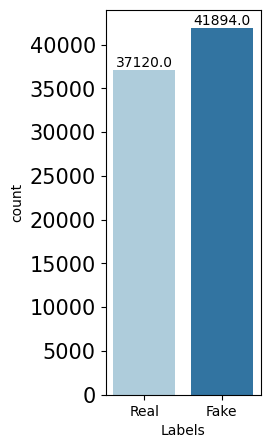

In [ ]:
labeled_barplot(data, 'Labels')

- this plot indicates that there are more observations that are fake news than real news in the data.

## Run the Pycaret pipeline with new data

In [ ]:
save_path = '/content/MyDrive/MyDrive/fake_news_project/new_combined_data.csv'

In [ ]:
top_models_new = ml_compare(save_path)
top_models_new

In [ ]:
setup_new = setting(save_path)

## Load the new data

In [ ]:
path = '/content/MyDrive/MyDrive/fake_news_project/new_combined_data.csv'
data = data_reader(path)
data.head()

,Text,Labels
0,say annies list political group support third trimester abortion demand,1
1,decline coal start started natural gas took started begin president george w bush administration,0
2,hillary clinton agrees john mccain voting give george bush benefit doubt iran,0
3,health care reform legislation likely mandate free sex change surgery,1
4,economic turnaround started end term,0


## Obtaining Sparse Vector Representation of Texts.

In [ ]:
def vectorizer(path, type_='tfidf'):
  """
  returns tfidf vector representation of text data from corpus
  args:
    path: path to data
    type_: default 'tfidf'. specified the vectorization to be implemented. values should be either 'tfidf' or 'bow'
    for TF-IDf or CountVectorizer respectively.
  """
  #read data from storage
  data = data_reader(path)

  #select feature and target
  feat = data['Text']
  target = data['Labels']

  if type_ == 'tfidf':
    #initialize the vectorizer
    tfidf = TfidfVectorizer(max_features=500)
    #fit vectorizer to data
    feat = tfidf.fit_transform(feat).toarray()
    #save the vectorizer to a variable
    vec = tfidf


  elif type_ == 'bow':
    #initialize the BOW vectorizer
    bow = CountVectorizer(max_features=500)
    #fit vectorizer to data
    feat = bow.fit_transform(feat).toarray()
    #save the vectorizer to a variable
    vec = bow

  #split the data into train, validation and test
  x_train, x_V, y_train, y_V = train_test_split(feat, target, random_state=1000, test_size = 0.2, stratify=target)
  x_val, x_test, y_val, y_test = train_test_split(x_V, y_V, random_state=1000,test_size = 0.5, stratify=y_V)

  return x_train, x_val, x_test, y_train, y_val, y_test, vec,




In [ ]:
#get the TF-idf features
x_train, x_val, x_test, y_train, y_val, y_test, tfidf = vectorizer(path=path, type_='tfidf')


#display the feature using a dataframe
pd.DataFrame(x_test).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.000000,0.0,0.0,0.040069,0.0,0.0,0.035593,0.0,...,0.000000,0.030675,0.0,0.034870,0.000000,0.038782,0.151810,0.000000,0.035831,0.047242
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.029125,0.0,...,0.036023,0.000000,0.0,0.028533,0.000000,0.000000,0.020704,0.000000,0.000000,0.000000
2,0.0,0.0,0.088727,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.126903,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.033353,0.0,...,0.041252,0.086233,0.0,0.032676,0.065778,0.036341,0.047419,0.077331,0.000000,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.055142,0.000000,0.029813,0.000000,0.000000,0.000000


## Obtain Bag-of-words (BOW) representation of texts

In [ ]:
#get the bow features and bow vectorizer
x_train_bw, x_val_bw, x_test_bw, y_train_bw, y_val_bw, y_test_bw, bow = vectorizer(path=path, type_='bow')



In [ ]:
#display the feature using a dataframe
pd.DataFrame(x_test_bw).head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,1,0,0,1,0,...,0,1,0,1,0,1,6,0,1,1
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,1,3,0,1,3,1,2,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,1,0,0,0


## obtain Denser Vector representations of the texts

In [ ]:
#import relevant packages
from gensim.models import Word2Vec
def sg_vocab(path):
  """
  constructs a skipgram model of 100-D with  words with minimum count > 5
  """
  data = data_reader(path=path)
  #append all comments in a list
  parent_list = []

  #for each row of Text column
  for comments in data['Text']:
    #split each string into a list of strings
    tokens = comments.split()

    #append the list into the parent list
    parent_list.append(tokens)

  #define the word2vec (skipgram) model of 100-Dimension with
  wv_model = Word2Vec(sentences=parent_list, min_count=5, sg=1)

  return  wv_model, parent_list

In [ ]:
wv_m, parent_list = sg_vocab(path)
wv_m

In [ ]:
#save the word2vec model
#wv_m.save("/content/MyDrive/MyDrive/fake_news_project/models/wv_m.model")

In [ ]:
#load the wv_m vector
#wv_m = Word2Vec.load("/content/MyDrive/MyDrive/fake_news_project/models/wv_m.model")


In [ ]:
def word_embeddings_getter(model, token_list):
    """
    this function returns an array of word-embedding vectors for each token found in the list of tokens
    model: model
    token_list: each itirative sentence in a list

    """
    embeddings = []
    vocab = set(model.wv.key_to_index) #get vocabulary

    for token in token_list: #for each  word in token_list
        if token in vocab: #if the token (word) is found in the vocab
            embeddings.append(model.wv.get_vector(token))#append the word embeddings to the list

    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    else:
        return(np.mean(embeddings, axis=0)) #return the mean of word embeddings for each word

def avg_word_emb(model, sentence):
    """
    this function applies the get_word_embeddings on each sentence
    model: model
    sentence: list containing a list of tokens
    """

    for token_list in sentence:

        word_embedding = [word_embeddings_getter(model, token_list) for token_list in sentence]
        #this will put every averaged word embedding for each sentence in a list hence we are able to retain the
        #shape of the array

        return np.array(word_embedding)

In [ ]:
#step4: get the word embeddings
sg_feat = avg_word_emb(model=wv_m, sentence=parent_list)
target = data.Labels


In [ ]:
pd.DataFrame(sg_feat)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.266650,0.112299,0.155621,0.067788,-0.283664,0.145642,0.296157,0.423550,-0.407985,-0.222132,...,-0.094094,-0.000196,-0.143944,0.086799,0.215585,-0.107819,0.050964,-0.204091,0.176535,0.108403
1,0.149131,0.009850,0.110000,-0.195155,-0.156932,0.217232,0.377037,0.042416,-0.180387,-0.320701,...,-0.182227,0.021389,-0.082182,-0.004029,0.065997,0.022456,-0.155009,-0.108662,-0.171989,0.093513
2,0.207049,0.113316,0.219887,-0.047699,-0.020905,0.229244,0.464223,0.210166,-0.176487,-0.294974,...,-0.051821,-0.227295,-0.159001,0.250865,0.091762,-0.098345,-0.158058,-0.151953,-0.049665,0.137044
3,0.187887,0.022835,0.183501,0.054437,-0.080057,0.234035,0.455087,0.330816,-0.475554,-0.443535,...,0.024366,0.074129,-0.239178,0.109611,0.206718,-0.022690,0.043363,-0.072804,0.302597,0.124807
4,0.271875,-0.059191,-0.051998,-0.050992,-0.276418,0.173305,0.323480,0.130132,-0.302019,-0.548219,...,-0.149506,0.107579,-0.017537,0.217788,0.272771,-0.183778,-0.008263,-0.376027,-0.030469,0.139730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80053,0.264162,0.129500,0.212578,0.047637,-0.032016,0.061619,0.439838,0.278142,-0.239123,-0.306573,...,-0.070379,0.029868,-0.114348,-0.068873,0.161064,-0.110461,-0.105259,-0.200360,0.066914,0.065125
80054,0.091804,0.185093,-0.022183,-0.114614,-0.078351,0.017454,0.430901,0.245701,-0.234589,-0.036970,...,-0.026023,0.383793,0.166851,-0.144348,0.223124,-0.136500,0.212661,-0.280770,0.240120,0.026546
80055,0.159338,0.085636,0.084696,0.108599,-0.131680,0.116128,0.303298,0.228576,-0.317472,-0.198046,...,-0.219933,0.110690,0.031679,-0.027578,0.336922,-0.129495,-0.061799,-0.159585,0.150437,0.019186
80056,0.162526,0.086999,0.117892,0.074081,-0.105581,0.116130,0.367507,0.320417,-0.344577,-0.200532,...,-0.109802,0.009307,-0.038819,-0.048532,0.225614,-0.173713,-0.058337,-0.202009,0.180298,0.057449


In [ ]:
x_train_sg, x_V, y_train_sg, y_V = train_test_split(sg_feat, target, random_state=0,stratify=target,
                                                   test_size=0.2)
x_val_sg, x_test_sg, y_val_sg, y_test_sg = train_test_split(x_V, y_V, random_state=0,stratify=y_V,
                                                   test_size=0.5)

## Define a function to pLot Important Features of the tree based models.

In [ ]:
def plot_feat_importances(model, X, n=100, vec='bow'):
    """
    plots a horizontal barplot for n number of feature importance of the model
    args:
      model :  model
      X : x_train
      n: number of features default is 100.
      vec: vectorization method employed ('bow' or 'tfidf') default is 'bow'
    """
    #important features
    important_feat = model.feature_importances_
    #index of sorted important features
    ind = np.argsort(important_feat)[:n]

    #set the figures size
    plt.figure(figsize=(5,10))
    #plot the horizontal bar plot
    plt.barh(y = range(len(ind)), width=important_feat[ind])
    #set the title
    plt.title("Relative Feature Importances")
    #label the y-axis
    plt.ylabel("Features")
    #set the ticks of the y-axis to be the name of the words that helped the model
    if vec == 'bow':
      plt.yticks(ticks=range(len(ind)), labels=[bow.get_feature_names_out()[i] for i in ind])
    elif vec == 'tfidf':
      plt.yticks(ticks=range(len(ind)), labels=[tfidf.get_feature_names_out()[i] for i in ind])

    #label the x axis
    plt.xlabel("Importance")
    #display the plot
    plt.show()

## Build a Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
def model_trainer(algo, x_train, y_train):
  """
  returns a trained model
  attr:
  algo (required) specified algorithm to be trained
  x_train (array) features
  y_train: target
  """
  model = algo.fit(x_train, y_train)

  #make predictions
  pred = model.predict(x_train)

  #compute accuracy score
  acc = accuracy_score(y_train, pred)
  print(f"Accuracy score: {acc}")

  return model

def model_eval(model, x_val, y_val):
  """
  evaluates a trained model's performance on validation sets
  attr:
  model (required) trained algorithm
  x_val (array) features
  y_val: target
  """
  model
  #make predicition using val set
  y_pred = model.predict(x_val)

  #print classification report
  print(classification_report(y_val, y_pred))

  return y_pred

## Evaluating Logistic Model performance on TFIDF features

In [ ]:
log_reg = LogisticRegression(random_state=0)
model = model_trainer(log_reg, x_train, y_train)

y_pred = model_eval(model, x_val, y_val)

Accuracy score: 0.8759551343911661
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3712
           1       0.90      0.85      0.87      4189

    accuracy                           0.87      7901
   macro avg       0.87      0.87      0.87      7901
weighted avg       0.87      0.87      0.87      7901



- we observed a much improved performance as summarized below.
- Precision:
  - 84% and 90% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 89% and 85% of the model's predictions for the Tre and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 87% of the model's total predictions were correct.

## Evaluating Logistic Model performance on BOW features

In [ ]:
log_reg = LogisticRegression(random_state=0)
model = model_trainer(log_reg, x_train_bw, y_train_bw)

y_pred = model_eval(model, x_val_bw, y_val_bw)

Accuracy score: 0.884197370710794
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      3712
           1       0.94      0.82      0.87      4189

    accuracy                           0.87      7901
   macro avg       0.88      0.88      0.87      7901
weighted avg       0.88      0.87      0.87      7901



- we observed a much improved performance as summarized below.
- Precision:
  - 82% and 94% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 94% and 82% of the model's predictions for the True and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 87% of the model's total predictions were correct.

## Evaluating Logistic Model performance on SkipGram features

In [ ]:
log_reg = LogisticRegression(random_state=0)
model = model_trainer(log_reg, x_train_sg, y_train_sg)

y_pred = model_eval(model, x_val_sg, y_val_sg)

Accuracy score: 0.8282952877619211
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      3554
           1       0.83      0.86      0.85      4452

    accuracy                           0.83      8006
   macro avg       0.82      0.82      0.82      8006
weighted avg       0.82      0.83      0.82      8006



- The logistic regression model did not perform better when the skip gram features were used.
- only 83% of the model's total predictions were correct as opposed to 87% when sparse vectors (BOW and TFIDF) were used.

## Evaluating the RandomForest Classifier performance using the TFIDF features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
rf = RandomForestClassifier(random_state=0, n_estimators=100)

model = model_trainer(rf, x_train, y_train)

y_pred = model_eval(model, x_val, y_val)

Accuracy score: 0.9948743098511335
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3712
           1       0.91      0.84      0.88      4189

    accuracy                           0.88      7901
   macro avg       0.88      0.88      0.88      7901
weighted avg       0.88      0.88      0.88      7901



- we observed a much improved performance as summarized below.
- Precision:
  - 84% and 91% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 91% and 84% of the model's predictions for the Tre and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 88% of the model's total predictions were correct.

## Plotting important Features
- this will display top 50 words that were most useful to the model in classification.

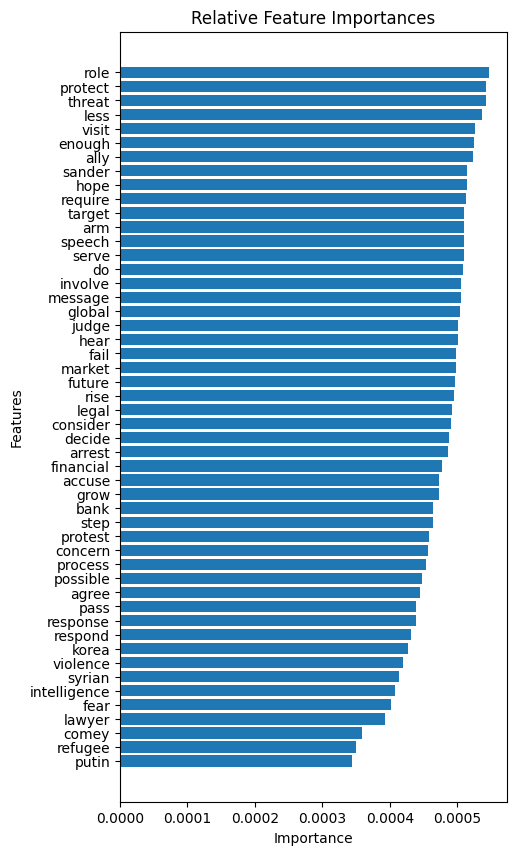

In [ ]:
plot_feat_importances(model, x_train, n=50, vec='tfidf')

- The plot shows top 50 words that were most useful to the model in classification. However, we can see that their degree of importance were not high, as the highest value of importance was not up t0 0.0006

## Evaluating the RandomForest Classifier performance using the BOW features.

In [ ]:
rf = RandomForestClassifier(random_state=0, n_estimators=100)

model = model_trainer(rf, x_train_bw, y_train_bw)

y_pred = model_eval(model, x_val_bw, y_val_bw)

Accuracy score: 0.9949692300390754
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3712
           1       0.90      0.86      0.88      4189

    accuracy                           0.88      7901
   macro avg       0.88      0.88      0.88      7901
weighted avg       0.88      0.88      0.88      7901



- we observed a much improved performance as summarized below.
- Precision:
  - 85% and 90% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 89% and 86% of the model's predictions for the Tre and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 88% of the model's total predictions were correct.
  - the training accuracy is much higher than the validation accuracy and this hints towards over-fitting.

## Plotting important Features
- this will display top 50 words that were most useful to the model in classification.

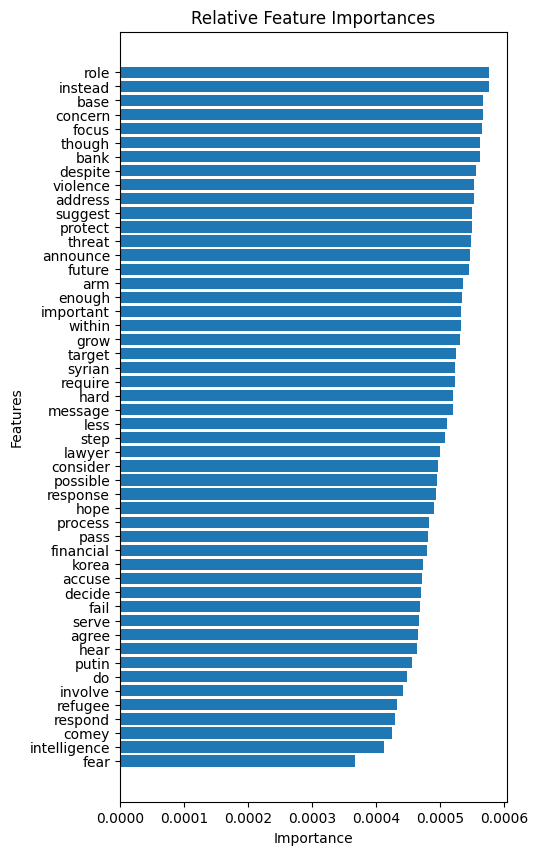

In [ ]:
plot_feat_importances(model, x_train_bw, n=50, vec='bow')

- The plot shows top 50 words that were most useful to the model in classification. However, we can see that their degree of importance were not high, as the highest value of importance was not up t0 0.0006.
- The word 'role' still appeared as the top word that is very useful to the model.

## Evaluating the RandomForest Classifier performance using the SkipGram features.

In [ ]:
rf = RandomForestClassifier(random_state=0, n_estimators=100)

model = model_trainer(rf, x_train_sg, y_train_sg)

y_pred = model_eval(model, x_val_sg, y_val_sg)

Accuracy score: 0.9999063173344159
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3554
           1       0.84      0.85      0.85      4452

    accuracy                           0.83      8006
   macro avg       0.83      0.82      0.82      8006
weighted avg       0.83      0.83      0.83      8006



- the model tends to be overfiting on the skipgram features because the training accuracy is 0.9999 while the validation accuracy is 0.83.


## Exploring the performance of the Gradient Boosting Model on the TFIDF features

In [ ]:
grb = GradientBoostingClassifier(random_state=0)

model = model_trainer(grb, x_train, y_train)

y_pred = model_eval(model, x_val, y_val)

Accuracy score: 0.8867443957539036
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3712
           1       0.95      0.81      0.88      4189

    accuracy                           0.88      7901
   macro avg       0.89      0.88      0.88      7901
weighted avg       0.89      0.88      0.88      7901



- The performance of the GradientBoosting classifier is summarized below.
- Precision:
  - 82% and 95% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 95% and 81% of the model's predictions for the True and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 88% of the model's total predictions were correct.
  - the training accuracy is in a similar range with the validation accuracy.

## Plotting important Features
- this will display top 50 words that were most useful to the model in classification.

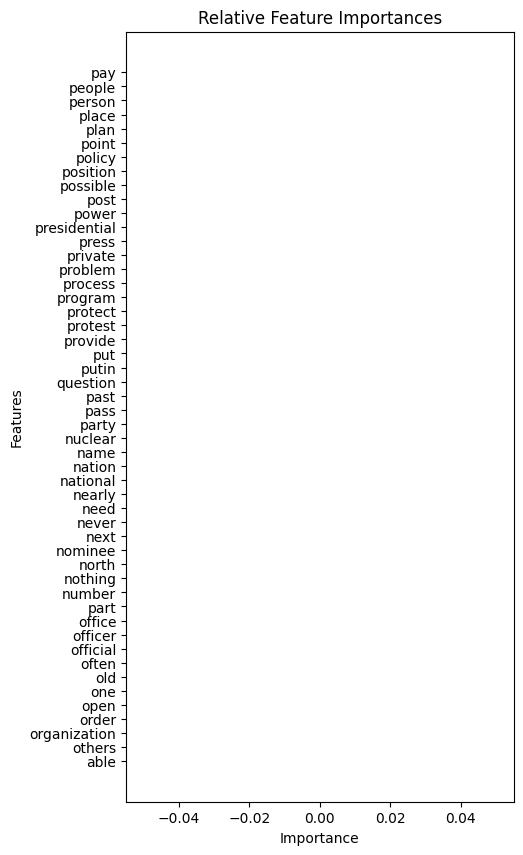

In [ ]:
plot_feat_importances(model, x_train, n=50, vec='tfidf')

- The plot shows top 50 words that were most useful to the gradient boosing model in classification.
- Sadly their contributions were very minute.

## Exploring the performance of the Gradient Boosting Model on the BOW features

In [ ]:
grb = GradientBoostingClassifier(random_state=0)

model = model_trainer(grb, x_train_bw, y_train_bw)

y_pred = model_eval(model, x_val_bw, y_val_bw)

Accuracy score: 0.8855420733733053
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3712
           1       0.95      0.81      0.88      4189

    accuracy                           0.88      7901
   macro avg       0.88      0.88      0.88      7901
weighted avg       0.89      0.88      0.88      7901



- The performance of the GradientBoosting classifier is summarized below.
- Precision:
  - 82% and 95% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 95% and 81% of the model's predictions for the True and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 88% of the model's total predictions were correct.

## Plotting important Features
- this will display top 50 words that were most useful to the model in classification.

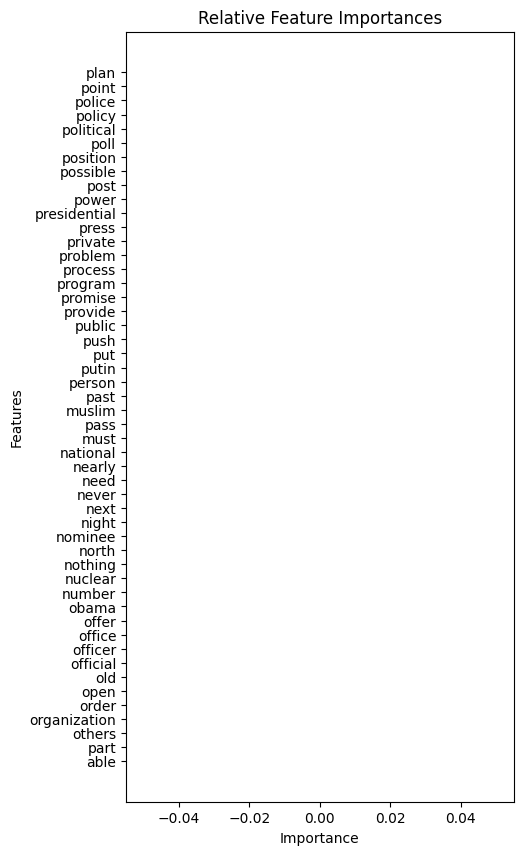

In [ ]:
plot_feat_importances(model, x_train_bw, n=50, vec='bow')

- The plot shows top 50 words that were most useful to the gradient boosing model in classification.
- Sadly their contributions were very minute but we can see that there were some common words identified by the GradientBoosting model when the bow and tf-idf were used.

## Exploring the performance of the Gradient Boosting Model on the SkipGram features

In [ ]:
grb = GradientBoostingClassifier(random_state=0)

model = model_trainer(grb, x_train_sg, y_train_sg)

y_pred = model_eval(model, x_val_sg, y_val_sg)

Accuracy score: 0.8337947509136068
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      3712
           1       0.85      0.84      0.84      4189

    accuracy                           0.83      7901
   macro avg       0.83      0.83      0.83      7901
weighted avg       0.83      0.83      0.83      7901



- the GradientBoosting model is not overfiting on the skipgram features however, the performance is still lower when compared with the sparse representations

## Exploring the performance of the ExtraTree Model on the SkipGram features

In [ ]:
xtree = ExtraTreesClassifier(random_state=0)

model = model_trainer(xtree, x_train_sg, y_train_sg)

y_pred = model_eval(model, x_val_sg, y_val_sg)

Accuracy score: 0.9999683599373527
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      3712
           1       0.88      0.83      0.85      4189

    accuracy                           0.85      7901
   macro avg       0.85      0.85      0.85      7901
weighted avg       0.85      0.85      0.85      7901



- The performance of the extratrees classifier on the skipgram embeddings is summarized below.
- Precision:
  - 82% and 88% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 87% and 83% of the model's predictions for the True and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 85% of the model's total predictions were correct.
- However, the discrepancy between the training accuracy and validation error indicate some level or possibility of overfitting.

## Exploring the performance of the ExtraTree Model on the TFIDF features

In [ ]:
xtree = ExtraTreesClassifier(random_state=0)

model = model_trainer(xtree, x_train, y_train)

y_pred = model_eval(model, x_val, y_val)

Accuracy score: 0.9948743098511335
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      3712
           1       0.89      0.85      0.87      4189

    accuracy                           0.87      7901
   macro avg       0.87      0.87      0.87      7901
weighted avg       0.87      0.87      0.87      7901



- The performance of the GradientBoosting classifier is summarized below.
- Precision:
  - 84% and 89% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 89% and 85% of the model's predictions for the True and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 87% of the model's total predictions were correct.
- However, the discrepancy between the training accuracy and validation error indicate some level or possibility of overfitting.

In [ ]:
model

ExtraTreesClassifier(random_state=0)

## Plotting important Features
- this will display top 50 words that were most useful to the model in classification.

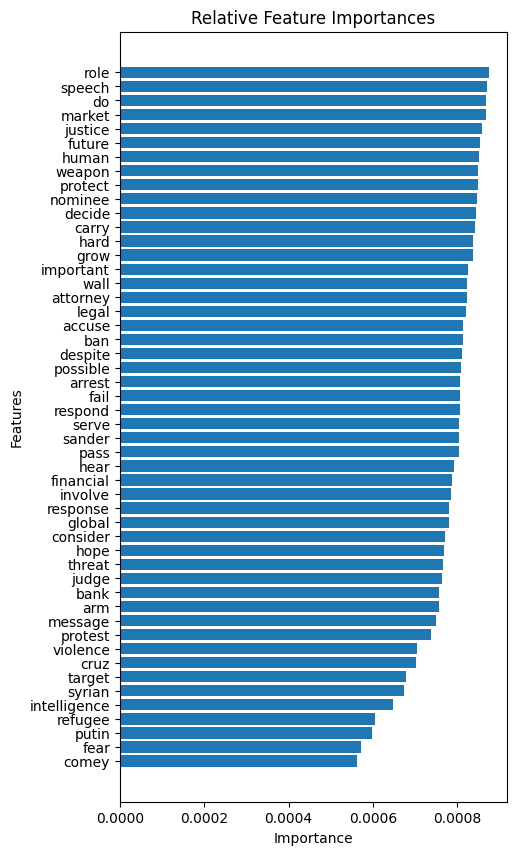

In [ ]:
plot_feat_importances(model, x_train, n=50, vec='tfidf')

- The plot shows top 50 words that were most useful to the ExtraTrees model in classification.
- Given the higher importance score, the model perceives them to be of higher importance than other models reviewed thus far.

## Exploring the performance of the ExtraTree Model on the BOW features

In [ ]:
xtree = ExtraTreesClassifier(random_state=0)

model = model_trainer(xtree, x_train_bw, y_train_bw)

y_pred = model_eval(model, x_val_bw, y_val_bw)

Accuracy score: 0.9949692300390754
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      3712
           1       0.88      0.86      0.87      4189

    accuracy                           0.86      7901
   macro avg       0.86      0.86      0.86      7901
weighted avg       0.86      0.86      0.86      7901



- The performance of the GradientBoosting classifier is summarized below.
- Precision:
  - 85% and 88% of the model's predictions for the True and Fake news categories in the validAtion set respectively were correct.
- Recall
  - 87% and 86% of the model's predictions for the True and Fake news categories respectively in the dataset were correct.
- Accuracy
  - 86% of the model's total predictions were correct.
- However, the discrepancy between the training accuracy and validation error indicate some level or possibility of overfitting.

## Plotting important Features
- this will display top 50 words that were most useful to the model in classification.

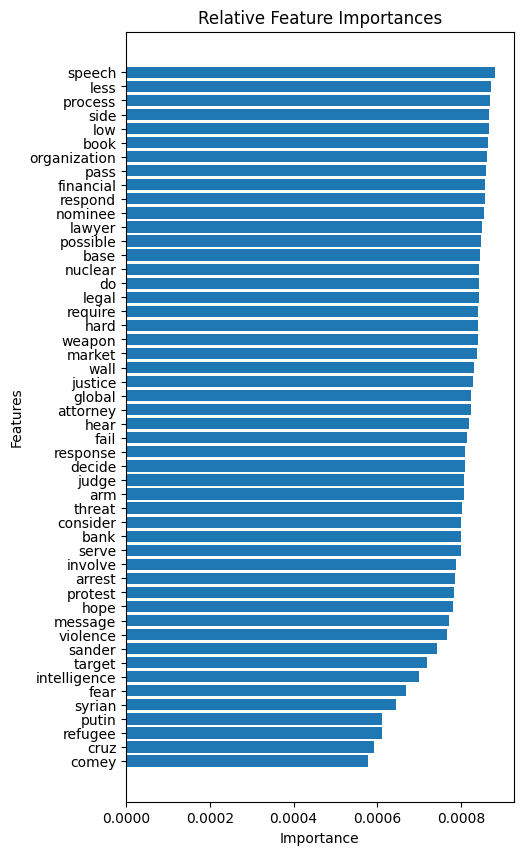

In [ ]:
plot_feat_importances(model, x_train_bw, n=50, vec='bow')

- The plot shows top 50 words that were most useful to the Extratrees model in classification.
- Sadly their contributions were very minute.

## Exploring Neural Network Models
## SimpleRNN

## Tokenize the texts


In [ ]:
df = data.copy()
df.head()

,Text,Labels
0,say annies list political group support third trimester abortion demand,1
1,decline coal start started natural gas took started begin president george w bush administration,1
2,hillary clinton agrees john mccain voting give george bush benefit doubt iran,0
3,health care reform legislation likely mandate free sex change surgery,1
4,economic turnaround started end term,1


In [ ]:
def vectorizer(path, num_words=1000):
  """
  this fn tokenizes the texts into a sequence of integers.
  path: file location in dir
  num_words: (default=1000) max number of unique words in the corpus to keep
  """
  #read data from storage
  df = data_reader(path)

  #instantiate the tokenizer
  tk = Tokenizer(num_words=num_words)

  #fit instance to text
  tk.fit_on_texts(df['Text'].values)

  #convert text to sequence of integers
  X = tk.texts_to_sequences(df['Text'].values)

  return X

In [ ]:
feature = vectorizer(path)
#feature


## pad the sequence
- to reduce the problem of sparisity, instead of using maximum length of comment as the max length, i will obtain the descriptive stats of the length of all the text as this will help me know the best padding length to use.

In [ ]:
pd.set_option("display.max_colwidth", None)

In [ ]:
length = []
#for each row in the data
for i in range(len(df['Text'].values)):
  #append the length of each string to the list
  length.append(len(df['Text'][i].split()))

#convert the list to a series
length_series = pd.Series(length)
#give a descriptive stats of it
print(length_series.describe())

count    80058.000000
mean       263.050164
std        315.362842
min          1.000000
25%         63.000000
50%        203.000000
75%        345.000000
max      11936.000000
dtype: float64


- the result indicates that 75% of the comments are not longer than 345 chars in length.
- the max. length of the comments however is 11,936.
- the minimum text is just a word.


#### i will set the maxlen of the padding operation to 300.

In [ ]:
def padder(path, time_steps=300):
  """
  pads the sequence to a unifrom length and split into train and test sets.
  path: specified directory
  time_steps: (default=300) specified length of each token sequence for truncation/padding operation
  """
  #get the tokenized text
  feature = vectorizer(path)

  #pad the sequence
  feature = pad_sequences(feature, maxlen=time_steps)

  #specify taregt
  target = df.Labels

  #split feature and target to train and test sets
  x_train, x_test, y_train, y_test = train_test_split(feature, target, random_state=0,stratify=target,
                                                   test_size=0.2)

  return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = padder(path)

print(f'{x_train.shape}\n {y_train.shape}')

(64046, 300)
 (64046,)


## Encode Target

In [ ]:
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)

## define the metrics

In [ ]:
import tensorflow as tf
#define metrics
indices = [

       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
       tf.keras.metrics.Precision(name='precision'),
       tf.keras.metrics.Recall(name='recall'),
       tf.keras.metrics.AUC(name='auc')
]

## define callbacks

In [ ]:
# import os
# os.mkdir(os.path.join('/content/MyDrive/MyDrive/fake_news_project/', 'combined_dataset_model'))

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=5)

#define modelcheckpoint to save best model

#path to project directory specially for models
temporal_path = '/content/MyDrive/MyDrive/fake_news_project/combined_dataset_model'

rnn_mc = ModelCheckpoint(filepath = temporal_path, save_best_only=True, monitor='val_accuracy', mode='max')


## clear backend

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

##  build the model

In [ ]:
def RNN_model(embedding_dims=100, hidden_dims=32):
    model = Sequential()

    #obtain dense vectors of 100D
    model.add(Embedding(1000, output_dim=embedding_dims,input_length=x_train.shape[1]))
    #apply dropout
    model.add(SpatialDropout1D(0.2))
    #add a vanilla rnn for recurrent operation
    model.add(SimpleRNN(units=hidden_dims))
    #add a dense layer for further representation
    model.add(Dense(units=16, activation='relu'))
    #add a dense layer for classification
    model.add(Dense(y_train.nunique(), activation ='sigmoid'))

    #compile the network
    model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

    return model

In [ ]:
rnn_1 = RNN_model()

rnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 104818 (409.45 KB)
Trainable params: 104818 (409.45 KB)
Non-trainable params: 0 (0.00 Byte)
________________

## train and evaluate the model

In [ ]:
#train the network
history = rnn_1.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=30, callbacks=[es, rnn_mc])

Epoch 1/30
801/801 [==============================] - 294s 356ms/step - loss: 0.3969 - accuracy: 0.7996 - precision: 0.8023 - recall: 0.7953 - auc: 0.8976 - val_loss: 0.3464 - val_accuracy: 0.8407 - val_precision: 0.8439 - val_recall: 0.8360 - val_auc: 0.9260
Epoch 2/30
801/801 [==============================] - 269s 336ms/step - loss: 0.3197 - accuracy: 0.8436 - precision: 0.8488 - recall: 0.8362 - auc: 0.9351 - val_loss: 0.3561 - val_accuracy: 0.8342 - val_precision: 0.8425 - val_recall: 0.8220 - val_auc: 0.9214
Epoch 3/30
801/801 [==============================] - 267s 333ms/step - loss: 0.2960 - accuracy: 0.8537 - precision: 0.8603 - recall: 0.8446 - auc: 0.9439 - val_loss: 0.3119 - val_accuracy: 0.8422 - val_precision: 0.8498 - val_recall: 0.8315 - val_auc: 0.9370
Epoch 4/30
801/801 [==============================] - 268s 335ms/step - loss: 0.3452 - accuracy: 0.8338 - precision: 0.8402 - recall: 0.8245 - auc: 0.9244 - val_loss: 0.4009 - val_accuracy: 0.7783 - val_precision: 0.7960

### Visualize the RNN Model Performance

In [ ]:
def view_perf(history):
  """
  plots the accuracy, val_accuracy and recall_score against epochs
  """
  #define accuracy
  acc = history.history['accuracy']

  #define validation_accuracy
  val_acc = history.history['val_accuracy']

  #specify epochs
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (5,5)) #set figure size
  plt.plot(epochs, acc, label="Train Accuracy") #plot accuracy against epochs
  plt.plot(epochs, val_acc, label="validation Accuracy") #plot val_acc against epcohs
  plt.xlabel("Epochs")
  plt.ylabel("Categorical Accuracy Score")

  plt.legend(loc='best') #display the legends at the best location in the chart

  plt.show()#show the plot

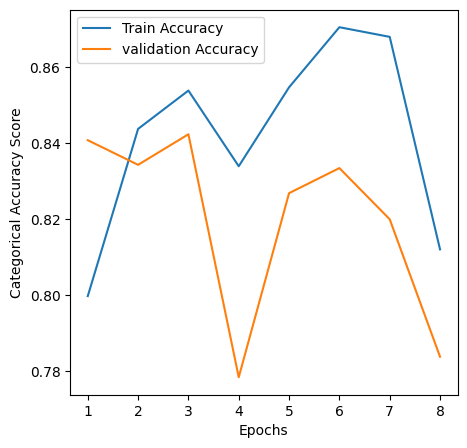

In [ ]:
view_perf(history)

- this chart indicates some level of overfiting accross all epochs except the 1st epoch.
- we will experiment further by adding Dropout layers.

In [ ]:
#evaluate performance on test set
rnn_1.evaluate(x_test, y_test_c)

501/501 [==============================] - 15s 28ms/step - loss: 0.4351 - accuracy: 0.7839 - precision: 0.7842 - recall: 0.7833 - auc: 0.8764


[0.43506813049316406,
 0.7839120626449585,
 0.7842316031455994,
 0.7833499908447266,
 0.8763958215713501]

- A similar low performance was observed on the test set. This confirms that the model is not generalizing well.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def RNN_model1(embedding_dims=100, hidden_dims=32):
    model = Sequential()

    #obtain dense vectors of 100D
    model.add(Embedding(1000, output_dim=embedding_dims,input_length=x_train.shape[1]))
    #apply dropout
    model.add(SpatialDropout1D(0.2))
    #add a vanilla rnn for recurrent operation
    model.add(SimpleRNN(units=hidden_dims))
    #add a dropout layer
    model.add(Dropout(0.2))
    #add a dense layer for further representation
    model.add(Dense(units=16, activation='relu'))
    #add a dense layer for classification
    model.add(Dense(y_train.nunique(), activation ='sigmoid'))

    #compile the network
    model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

    return model

In [ ]:
rnn_2 = RNN_model1()

rnn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                        

In [ ]:
#os.mkdir(os.path.join('/content/MyDrive/MyDrive/fake_news_project/combined_dataset_model', 'model2'))

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=5)

#define modelcheckpoint to save best model

#path to project directory specially for models
temporal_path = '/content/MyDrive/MyDrive/fake_news_project/combined_dataset_model/model2'

rnn_mc = ModelCheckpoint(filepath = temporal_path, save_best_only=True, monitor='val_accuracy', mode='max')


## train and evaluate the model

In [ ]:
#train the network
history = rnn_2.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=30, callbacks=[es, rnn_mc])

Epoch 1/30
801/801 [==============================] - 270s 334ms/step - loss: 0.4168 - accuracy: 0.7926 - precision: 0.7960 - recall: 0.7869 - auc: 0.8847 - val_loss: 0.4078 - val_accuracy: 0.8157 - val_precision: 0.8181 - val_recall: 0.8119 - val_auc: 0.8947
Epoch 2/30
801/801 [==============================] - 259s 323ms/step - loss: 0.4228 - accuracy: 0.8004 - precision: 0.8017 - recall: 0.7983 - auc: 0.8855 - val_loss: 0.3599 - val_accuracy: 0.8261 - val_precision: 0.8253 - val_recall: 0.8274 - val_auc: 0.9201
Epoch 3/30
801/801 [==============================] - 250s 311ms/step - loss: 0.4495 - accuracy: 0.7785 - precision: 0.7771 - recall: 0.7811 - auc: 0.8687 - val_loss: 0.4522 - val_accuracy: 0.7784 - val_precision: 0.7785 - val_recall: 0.7782 - val_auc: 0.8667
Epoch 4/30
801/801 [==============================] - 260s 325ms/step - loss: 0.4060 - accuracy: 0.8038 - precision: 0.8033 - recall: 0.8047 - auc: 0.8946 - val_loss: 0.3759 - val_accuracy: 0.8093 - val_precision: 0.8052

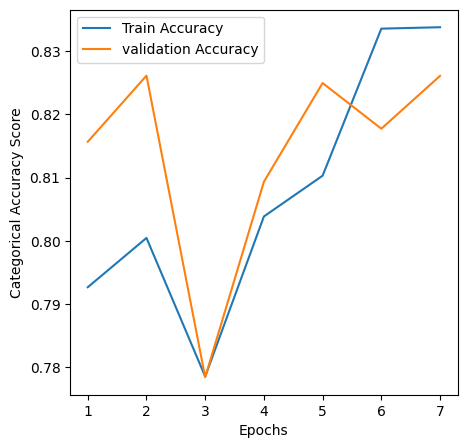

In [ ]:
view_perf(history)

- this chart indicates a stronger level of generalization compared to the prior experiment without dropout layers.
- the validation recall was lower at the 6th and 7th epochs.


In [ ]:
#evaluate performance on test set
rnn_2.evaluate(x_test, y_test_c)

501/501 [==============================] - 15s 29ms/step - loss: 0.3289 - accuracy: 0.8285 - precision: 0.8281 - recall: 0.8291 - auc: 0.9280


[0.32892438769340515,
 0.8285036087036133,
 0.8281347751617432,
 0.8290656805038452,
 0.9279682040214539]

- A similar low performance was observed on the test set. This confirms that the model is generalizing well.

## Balancing the Dataset by using class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute class weight for each subcategory of the target
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = dict(enumerate(class_weight))
class_weight_dic


{0: 1.126103316102261, 1: 0.8992951220197141}

## Build an RNN network that takes cognizance of the weight of each classes.
- the reason behind this approach is to train the model to have a balanced view of each subcategory as this might reduce the level of overfiting.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

##  build the model

In [ ]:
rnn_2 = RNN_model1()

rnn_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                        

## train and evaluate the model

In [ ]:
history = rnn_2.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=30, callbacks=[es, rnn_mc], class_weight=class_weight_dic)

Epoch 1/30
801/801 [==============================] - 277s 342ms/step - loss: 0.4369 - accuracy: 0.8056 - precision: 0.8048 - recall: 0.8069 - auc: 0.8918 - val_loss: 0.3368 - val_accuracy: 0.8274 - val_precision: 0.8321 - val_recall: 0.8205 - val_auc: 0.9272
Epoch 2/30
801/801 [==============================] - 263s 329ms/step - loss: 0.3454 - accuracy: 0.8368 - precision: 0.8370 - recall: 0.8364 - auc: 0.9258 - val_loss: 0.3284 - val_accuracy: 0.8329 - val_precision: 0.8354 - val_recall: 0.8292 - val_auc: 0.9303
Epoch 3/30
801/801 [==============================] - 265s 331ms/step - loss: 0.3259 - accuracy: 0.8444 - precision: 0.8461 - recall: 0.8420 - auc: 0.9335 - val_loss: 0.3336 - val_accuracy: 0.8390 - val_precision: 0.8411 - val_recall: 0.8358 - val_auc: 0.9303
Epoch 4/30
801/801 [==============================] - 267s 333ms/step - loss: 0.3366 - accuracy: 0.8332 - precision: 0.8320 - recall: 0.8349 - auc: 0.9266 - val_loss: 0.3133 - val_accuracy: 0.8270 - val_precision: 0.8284

### Visualize the RNN Model Performance

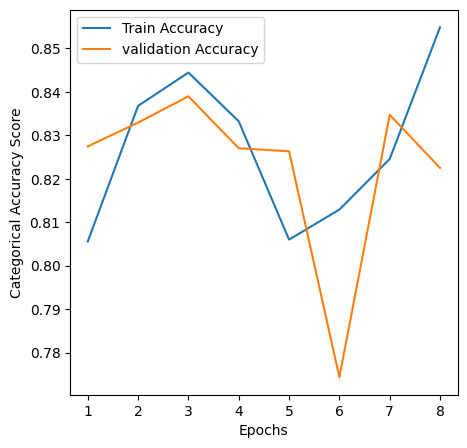

In [ ]:
view_perf(history)

- similarly, this chart indicates a strong level of overfiting accross all epochs.

In [ ]:
#evaluate performance on test set
rnn_2.evaluate(x_test, y_test_c)

501/501 [==============================] - 15s 30ms/step - loss: 0.3589 - accuracy: 0.8228 - precision: 0.8231 - recall: 0.8223 - auc: 0.9181


[0.3588809370994568,
 0.8227579593658447,
 0.8230807781219482,
 0.8222582936286926,
 0.918107271194458]

- balancing the weights did not show any improved performance on the recall.
- the model showed higher level of overfiting when the weights were balanced.

## Exploring Long Short Term Memory (LSTM) Network.
- LSTM uses the principle of 'Gating Mechanism' to understand and retain the long range dependencies in sequential data.
- It is able to prevent varnishing and exploding gradient problems that may reduce overfiting.
- However to also reduce overfiting, we will reduce the output_dimension of the embediing layer to 30.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def lstm(embedding_dims=100, hidden_dims=32):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings  30
  hidden_dims: number of neurons
  """
  #define structure to be a linear stack of layers
  model = Sequential()

  #add an ebedding layer to obtain dense representation of text sequence
  model.add(Embedding(1000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  #add an LSTM layer
  model.add(LSTM(units=hidden_dims))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))

  #add a dense
  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

  return model

In [ ]:
# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

# #define modelcheckpoint to save best model
path = '/content/MyDrive/MyDrive/fake_news_project/models'
lstm_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
lstm_1 = lstm()

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 117586 (459.32 KB)
Trainable params: 117586 (459.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#train the network
lstm_history = lstm_1.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, lstm_mc])

Epoch 1/15
801/801 [==============================] - 35s 36ms/step - loss: 0.3573 - accuracy: 0.8251 - precision: 0.8282 - recall: 0.8204 - auc: 0.9181 - val_loss: 0.3374 - val_accuracy: 0.8130 - val_precision: 0.8233 - val_recall: 0.7972 - val_auc: 0.9207
Epoch 2/15
801/801 [==============================] - 18s 22ms/step - loss: 0.2997 - accuracy: 0.8463 - precision: 0.8474 - recall: 0.8447 - auc: 0.9405 - val_loss: 0.3005 - val_accuracy: 0.8510 - val_precision: 0.8502 - val_recall: 0.8521 - val_auc: 0.9431
Epoch 3/15
801/801 [==============================] - 15s 19ms/step - loss: 0.2784 - accuracy: 0.8578 - precision: 0.8565 - recall: 0.8596 - auc: 0.9493 - val_loss: 0.3146 - val_accuracy: 0.8324 - val_precision: 0.8247 - val_recall: 0.8441 - val_auc: 0.9322
Epoch 4/15
801/801 [==============================] - 17s 21ms/step - loss: 0.2730 - accuracy: 0.8606 - precision: 0.8601 - recall: 0.8613 - auc: 0.9511 - val_loss: 0.3126 - val_accuracy: 0.8281 - val_precision: 0.8287 - val_r

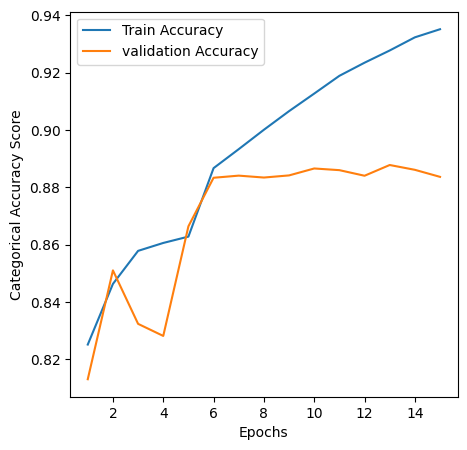

In [ ]:
view_perf(lstm_history)

- Higher performance was obtained using LSTM network. However, the model tends to be overfiting after the 6th epoch.

- The next approach will be to use L1 regularization on the recurrent_regularizer of the the LSTM layer. This may help reduce the level of overfiting observed.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def lstm2(embedding_dims=100, hidden_dims=32):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings default 100
  hidden_dims: number of neurons
  """
  model = Sequential()

  model.add(Embedding(1000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  model.add(LSTM(units=hidden_dims,recurrent_regularizer=keras.regularizers.l1(0.2)))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))

  #add a dropout layer
  model.add(Dropout(0.2))

  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

  return model

In [ ]:
# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

#define modelcheckpoint to save best model
path = '/content/MyDrive/MyDrive/fake_news_project/models/lstm2'

#create directory for saving model
#import os
#os.mkdir(path)

lstm2_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
lstm_2 = lstm2()

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 117586 (459.32 KB)
Trainable params: 117586 (459.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm2_history = lstm_2.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, lstm2_mc])

Epoch 1/15
801/801 [==============================] - 32s 35ms/step - loss: 4.5871 - accuracy: 0.8121 - precision: 0.8147 - recall: 0.8080 - auc: 0.9005 - val_loss: 0.4424 - val_accuracy: 0.8256 - val_precision: 0.8225 - val_recall: 0.8305 - val_auc: 0.9210
Epoch 2/15
801/801 [==============================] - 18s 22ms/step - loss: 0.4050 - accuracy: 0.8481 - precision: 0.8459 - recall: 0.8513 - auc: 0.9382 - val_loss: 0.3730 - val_accuracy: 0.8655 - val_precision: 0.8654 - val_recall: 0.8657 - val_auc: 0.9517
Epoch 3/15
801/801 [==============================] - 19s 24ms/step - loss: 0.3345 - accuracy: 0.8781 - precision: 0.8766 - recall: 0.8801 - auc: 0.9622 - val_loss: 0.3426 - val_accuracy: 0.8754 - val_precision: 0.8697 - val_recall: 0.8830 - val_auc: 0.9598
Epoch 4/15
801/801 [==============================] - 18s 23ms/step - loss: 0.3114 - accuracy: 0.8884 - precision: 0.8871 - recall: 0.8901 - auc: 0.9686 - val_loss: 0.3240 - val_accuracy: 0.8829 - val_precision: 0.8810 - val_r

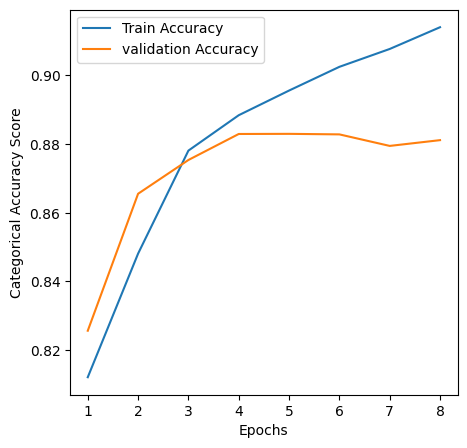

In [ ]:
view_perf(lstm2_history)

- a much stable performance was observed however, there is still some level of overfiting observed from the 3rd epoch

## Exploring Gated Recurrent Network
- The idea behind using GRU is that it is similar to LSTM as they are both able to handle long range inter dependencies. However, the LSTM network architecture is more complex than the GRU because unlike the lSTm that has 3 gates, the GRU has 2 gates namely: the reset gate and the update gate.
- The reset gate decides what information to forget from the previous state, and the update gate determines how much of the new information is incorporated into the current state.
- this simpler nature might help in reducing the overfiting observed thus far.

## clear backend

In [ ]:
#clear backend
backend.clear_session()

In [ ]:
def gru_n(embedding_dims=100, hidden_dims=32):
  """
  returns a compiled GRU architecture
  embedding_dims : the desired shape of embeddings default 300
  hidden_dims: number of neurons
  """
  model = Sequential()

  model.add(Embedding(1000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  model.add(GRU(units=hidden_dims, kernel_regularizer=keras.regularizers.l1(0.1), recurrent_regularizer=keras.regularizers.l1(0.1)))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))

  #add a dropoutlayer
  # model.add(Dropout(0.2))

  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

  return model

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=2, patience=3)

# define modelcheckpoint to save best model
path = '/content/MyDrive/MyDrive/fake_news_project/models/gru'
#os.mkdir(path)

gru_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_accuracy', mode='max')


In [ ]:
gru = gru_n()

gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          300000    
                                                                 
 gru (GRU)                   (None, 32)                32064     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 332626 (1.27 MB)
Trainable params: 332626 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history_gru = gru.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, gru_mc])

Epoch 1/15
801/801 [==============================] - 37s 39ms/step - loss: 12.4215 - accuracy: 0.5709 - precision: 0.5711 - recall: 0.5690 - auc: 0.5774 - val_loss: 1.0724 - val_accuracy: 0.5578 - val_precision: 0.5578 - val_recall: 0.5578 - val_auc: 0.6274
Epoch 2/15
801/801 [==============================] - 17s 21ms/step - loss: 1.0692 - accuracy: 0.5555 - precision: 0.5555 - recall: 0.5555 - auc: 0.5636 - val_loss: 1.0696 - val_accuracy: 0.5578 - val_precision: 0.5578 - val_recall: 0.5578 - val_auc: 0.6029
Epoch 3/15
801/801 [==============================] - 20s 25ms/step - loss: 1.0249 - accuracy: 0.6225 - precision: 0.6233 - recall: 0.6194 - auc: 0.6866 - val_loss: 0.9033 - val_accuracy: 0.7617 - val_precision: 0.7633 - val_recall: 0.7588 - val_auc: 0.8413
Epoch 4/15
801/801 [==============================] - 19s 23ms/step - loss: 0.8661 - accuracy: 0.7755 - precision: 0.7769 - recall: 0.7729 - auc: 0.8649 - val_loss: 0.8525 - val_accuracy: 0.7779 - val_precision: 0.7787 - val_

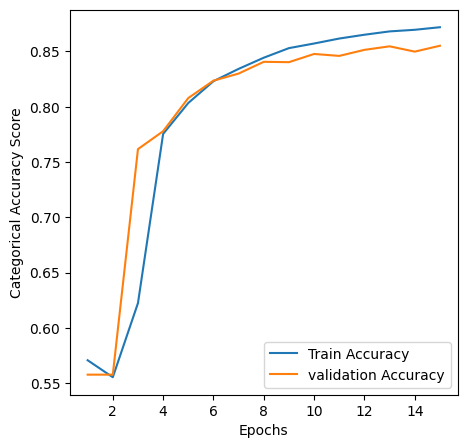

In [ ]:
view_perf(history_gru)

- so far, the GRU model showed lower degree of overfiting. However, a much lower range of validation accuracy was observed across all epochs compared to the LSTM model.

## BERT using Simple Transformers

In [ ]:
#!pip install simpletransformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from datasets import load_dataset
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split

In [ ]:
# load the dataset
path = r"C:\Users\User\Downloads\new_combined_data.csv"

df = pd.read_csv(path)

print(df.isnull().sum())

df.head()

Text      0
Labels    0
dtype: int64


,Text,Labels
0,say annies list political group support third ...,1
1,decline coal start started natural gas took st...,0
2,hillary clinton agrees john mccain voting give...,0
3,health care reform legislation likely mandate ...,1
4,economic turnaround started end term,0


In [ ]:
df["Labels"].value_counts(normalize = True)

1    0.53021
0    0.46979
Name: Labels, dtype: float64

## **Data Preparation**

In [ ]:
# rename the columns
df.rename(columns = {"Text": "text", "Labels": "labels"}, inplace = True)

# Split the data
X = df["text"]
y = df["labels"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # Ensure proper data types
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

# Concatenate features with targets
train_set = pd.concat([x_train, y_train], axis=1)
test_set = pd.concat([x_test, y_test], axis=1)

# reset the index
train_set.reset_index(drop = True, inplace = True)
test_set.reset_index(drop = True, inplace = True)

### **Model Training**

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1)

# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'bert-base-uncased',
    num_labels=2,
    args=model_args,
    use_cuda = False
)

# Train the model
print("==========================Training a BERT Model=================================")
model.train_model(train_set)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


==========================Training a BERT Model=================================


  0%|          | 0/63211 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/7902 [00:00<?, ?it/s]

(7902, 0.2628378779478733)

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_set)

  0%|          | 0/15803 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1976 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.8295466359106026,
 'tp': 7426,
 'tn': 7014,
 'fp': 410,
 'fn': 953,
 'auroc': 0.9793810039517924,
 'auprc': 0.9827338999837013,
 'eval_loss': 0.20140118089418288}

In [ ]:
test_set.reset_index(drop = True, inplace = True)

In [ ]:
test_tweets = []
for i in range(test_set.shape[0]):
    tweet = test_set["text"][i]
    test_tweets.append(tweet)

In [ ]:
# Make predictions with the model
predictions, raw_outputs = model.predict(test_tweets)

  0%|          | 0/15803 [00:00<?, ?it/s]

  0%|          | 0/1976 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# compute classification report
cls_report = classification_report(test_set["labels"],
                                   predictions,
                                   target_names = ["True", "Fake"])

print(f"Classification Report: \n {cls_report}")

Classification Report: 
               precision    recall  f1-score   support

        True       0.88      0.94      0.91      7424
        Fake       0.95      0.89      0.92      8379

    accuracy                           0.91     15803
   macro avg       0.91      0.92      0.91     15803
weighted avg       0.92      0.91      0.91     15803

